In [1]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('unique_companies.csv')

# Apply the filter
filtered_df = df[
    (df['GicSubIndustry'].isin(['Copper', 'Diversified Metals & Mining'])) |
    (df['Industry'] == 'Copper')
]

# Further filter to rows where 'Industry' is 'Other Industrial Metals & Mining' or 'Copper'
final_df = filtered_df[filtered_df['Industry'].isin(['Other Industrial Metals & Mining', 'Copper'])]

# Save the result to a new CSV if needed
final_df.to_csv('unique_companies_copper.csv', index=False)



/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/3907943495.py:4: DtypeWarning: Columns (11,13,23,24,75,76,79,80,83,84,90) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('unique_companies.csv')


In [2]:
import pandas as pd

# Read the CSV
df = pd.read_csv("unique_companies_copper.csv")

# Mapping dictionary
mapping = {
    "US": "",
    "LSE": ".L",
    "STU": ".SG",
    "KO": ".KS",
    "WAR": ".WA",
    "SHG": ".SS",
    "NSE": ".NS",
    "AU": ".AX",
    "JSE": ".JO",
    "KLSE": ".KL",
    "SHE": ".SZ"
}

def convert_ticker(ticker):
    try:
        base, suffix = ticker.split(".")
        if suffix in mapping:
            return base + mapping[suffix]
        else:
            return ticker  # leave unchanged if no match
    except ValueError:
        return ticker  # in case ticker doesn't contain "."
    
# Apply transformation
df["PrimaryTicker"] = df["PrimaryTicker"].apply(convert_ticker)

# Save the updated CSV
df.to_csv("unique_companies_copper_updated.csv", index=False)

print("Ticker transformation complete. Saved as unique_companies_copper_updated.csv")


Ticker transformation complete. Saved as unique_companies_copper_updated.csv


In [17]:
# ------------------------------------------------------------
# Build df_prices.csv for HG=F + tickers in unique_companies_copper.csv
# • period="5y" (more reliable than start/end for some venues)
# • Prefer 'Adj Close', fallback to 'Close'
# • Re-download single tickers that are all-NaN in batch (e.g., 2IK.F)
# ------------------------------------------------------------
# pip install yfinance pandas

import pandas as pd
import yfinance as yf

CSV_PATH = "unique_companies_copper_updated.csv"
TICKER_COL = "PrimaryTicker"
UNDERLYING = "HG=F"
BATCH_SIZE = 50
OUT_CSV   = "df_prices.csv"

# --- Read tickers ---
tickers = (
    pd.read_csv(CSV_PATH, usecols=[TICKER_COL])[TICKER_COL]
      .dropna().astype(str).str.strip().str.upper().tolist()
)
tickers = sorted(set(tickers))
if UNDERLYING not in tickers:
    tickers = [UNDERLYING] + tickers

print(f"Found {len(tickers)} tickers (including {UNDERLYING}).")

def _extract_adj_or_close(df_multi: pd.DataFrame) -> tuple[pd.DataFrame, list[str]]:
    """From yfinance multi-ticker frame, prefer 'Adj Close', else 'Close' per ticker."""
    if not isinstance(df_multi.columns, pd.MultiIndex):
        raise ValueError("Expected MultiIndex columns for multi-ticker download.")
    fields = set(df_multi.columns.get_level_values(-1))
    adj = df_multi.xs("Adj Close", axis=1, level=-1, drop_level=True) if "Adj Close" in fields else pd.DataFrame(index=df_multi.index)
    clo = df_multi.xs("Close",      axis=1, level=-1, drop_level=True) if "Close"      in fields else pd.DataFrame(index=df_multi.index)

    cols = sorted(set(adj.columns).union(clo.columns))
    out  = pd.DataFrame(index=df_multi.index, columns=cols, dtype="float64")
    used_close = []

    for t in cols:
        a = adj[t] if t in adj.columns else None
        c = clo[t] if t in clo.columns else None
        if a is not None and not a.dropna().empty:
            out[t] = a
        elif c is not None and not c.dropna().empty:
            out[t] = c
            used_close.append(t)
    return out, used_close

def _download_batch(batch):
    df = yf.download(
        tickers=batch,
        period="6y",
        interval="1d",
        auto_adjust=False,
        actions=False,
        progress=False,
        group_by="ticker",
        threads=True
    )
    if isinstance(df.columns, pd.MultiIndex):
        return _extract_adj_or_close(df)
    else:
        # Single-ticker shape
        tkr = batch[0]
        adj = df.get("Adj Close")
        clo = df.get("Close")
        used_close = []
        if adj is not None and not adj.dropna().empty:
            out = adj.rename(tkr).to_frame()
        elif clo is not None and not clo.dropna().empty:
            out = clo.rename(tkr).to_frame()
            used_close.append(tkr)
        else:
            out = pd.DataFrame(index=df.index, columns=[tkr], dtype="float64")
        return out, used_close

def _download_single(tkr: str) -> pd.Series:
    """Single-ticker repair path; prefer Adj Close, else Close."""
    df = yf.download(
        tickers=tkr,
        period="5y",
        interval="1d",
        auto_adjust=False,
        actions=False,
        progress=False
    )
    s = df.get("Adj Close")
    if s is None or s.dropna().empty:
        s = df.get("Close")
    if s is None:
        return pd.Series(dtype="float64", name=tkr)
    return s.rename(tkr)

# --- Batch download + merge ---
frames, used_close_all = [], []
for i in range(0, len(tickers), BATCH_SIZE):
    batch = tickers[i:i+BATCH_SIZE]
    print(f"Downloading batch {i//BATCH_SIZE + 1}: {len(batch)} tickers")
    part, used_close = _download_batch(batch)
    frames.append(part)
    used_close_all.extend(used_close)

df_prices = pd.concat(frames, axis=1)
df_prices = df_prices.loc[:, ~df_prices.columns.duplicated()].sort_index()

# --- Repair tickers that are NaN-only or missing after batch ---
to_repair = [t for t in tickers if (t in df_prices.columns and df_prices[t].dropna().empty) or (t not in df_prices.columns)]
to_repair = sorted(set(to_repair))
if to_repair:
    print(f"Repairing via single-ticker fetch: {to_repair}")
    for t in to_repair:
        s = _download_single(t)
        if not s.dropna().empty:
            df_prices = df_prices.reindex(df_prices.index.union(s.index)).sort_index()
            df_prices[t] = s.reindex(df_prices.index)

# --- Order columns; drop all-NaN tickers ---
ordered_cols = [UNDERLYING] + [t for t in tickers if t != UNDERLYING and t in df_prices.columns]
df_prices = df_prices.reindex(columns=ordered_cols)
all_nan_cols = [c for c in df_prices.columns if df_prices[c].dropna().empty]
if all_nan_cols:
    print(f"Dropping tickers with no usable data: {all_nan_cols}")
    df_prices = df_prices.drop(columns=all_nan_cols)

# --- Report fallback usage ---
used_close_all = sorted(set([t for t in used_close_all if t in df_prices.columns]))
if used_close_all:
    print(f"Used 'Close' fallback for: {used_close_all}")

print("df_prices shape:", df_prices.shape)
print("Columns:", list(df_prices.columns))

# --- Save ---
df_prices.to_csv(OUT_CSV, index_label="Date", float_format="%.6f")
print(f"Saved to '{OUT_CSV}'.")


Found 1830 tickers (including HG=F).



1 Failed download:
['5RJ.F']: YFPricesMissingError('possibly delisted; no price data found  (period=6y) (Yahoo error = "No data found, symbol may be delisted")')



1 Failed download:
['ACLHF']: YFPricesMissingError('possibly delisted; no price data found  (period=6y) (Yahoo error = "No data found, symbol may be delisted")')



2 Failed downloads:
['BR0.F', 'BMOOD']: YFPricesMissingError('possibly delisted; no price data found  (period=6y) (Yahoo error = "No data found, symbol may be delisted")')



1 Failed download:
['C0O.F']: YFPricesMissingError('possibly delisted; no price data found  (period=6y) (Yahoo error = "No data found, symbol may be delisted")')



2 Failed downloads:
['CMETF', 'CMDRF']: YFPricesMissingError('possibly delisted; no price data found  (period=6y) (Yahoo error = "No data found, symbol may be delisted")')



2 Failed downloads:
['ERW.AX', 'EROSF']: YFPricesMissingError('possibly delisted; no price data found  (period=6y) (Yahoo error = "No data found, symbol may be delisted")')



1 Failed download:
['GRFX']: YFPricesMissingError('possibly delisted; no price data found  (period=6y) (Yahoo error = "No data found, symbol may be delisted")')



1 Failed download:
['JRV.V']: YFPricesMissingError('possibly delisted; no price data found  (period=6y) (Yahoo error = "No data found, symbol may be delisted")')



1 Failed download:
['LLI.AX']: YFPricesMissingError('possibly delisted; no price data found  (period=6y) (Yahoo error = "No data found, symbol may be delisted")')



1 Failed download:
['MLYF']: YFPricesMissingError('possibly delisted; no price data found  (period=6y) (Yahoo error = "No data found, symbol may be delisted")')



2 Failed downloads:
['NALA.TA', 'NGLD.F']: YFPricesMissingError('possibly delisted; no price data found  (period=6y) (Yahoo error = "No data found, symbol may be delisted")')



3 Failed downloads:
['NSMCF', 'NOCRF', 'NVLIF']: YFPricesMissingError('possibly delisted; no price data found  (period=6y) (Yahoo error = "No data found, symbol may be delisted")')



1 Failed download:
['RCZRF']: YFPricesMissingError('possibly delisted; no price data found  (period=6y) (Yahoo error = "No data found, symbol may be delisted")')



1 Failed download:
['RLL.AX']: YFPricesMissingError('possibly delisted; no price data found  (period=6y) (Yahoo error = "No data found, symbol may be delisted")')



1 Failed download:
['SIE.V']: YFPricesMissingError('possibly delisted; no price data found  (period=6y) (Yahoo error = "No data found, symbol may be delisted")')



1 Failed download:
['SMCDF']: YFPricesMissingError('possibly delisted; no price data found  (period=6y) (Yahoo error = "No data found, symbol may be delisted")')



2 Failed downloads:
['VLV.V', 'V6Y.F']: YFPricesMissingError('possibly delisted; no price data found  (period=6y) (Yahoo error = "No data found, symbol may be delisted")')



1 Failed download:
['5RJ.F']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Repairing via single-ticker fetch: ['5RJ.F', 'ACLHF', 'BMOOD', 'BR0.F', 'C0O.F', 'CMDRF', 'CMETF', 'EROSF', 'ERW.AX', 'GRFX', 'JRV.V', 'LLI.AX', 'MLYF', 'NALA.TA', 'NGLD.F', 'NOCRF', 'NSMCF', 'NVLIF', 'RCZRF', 'RLL.AX', 'SIE.V', 'SMCDF', 'V6Y.F', 'VLV.V']



1 Failed download:
['ACLHF']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')

1 Failed download:
['BMOOD']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')

1 Failed download:
['BR0.F']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')

1 Failed download:
['C0O.F']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')

1 Failed download:
['CMDRF']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')

1 Failed download:
['CMETF']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')

1 Failed download:
['EROSF']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')

1 Failed download:
['ERW.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')

1 Failed download:
['GRFX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')

1 Failed download:
['JRV.V']: YFRateLimitError('Too Many Requests. Rate 

Dropping tickers with no usable data: ['5RJ.F', 'ACLHF', 'BMOOD', 'BR0.F', 'C0O.F', 'CMDRF', 'CMETF', 'EROSF', 'ERW.AX', 'GRFX', 'JRV.V', 'LLI.AX', 'MLYF', 'NALA.TA', 'NGLD.F', 'NOCRF', 'NSMCF', 'NVLIF', 'RCZRF', 'RLL.AX', 'SIE.V', 'SMCDF', 'V6Y.F', 'VLV.V']
df_prices shape: (1570, 1806)
Columns: ['HG=F', '000060.SZ', '000426.SZ', '000603.SZ', '000630.SZ', '000657.SZ', '000737.SZ', '000751.SZ', '000758.SZ', '000762.SZ', '000795.SZ', '000878.SZ', '000960.SZ', '000962.SZ', '000969.SZ', '002114.SZ', '002149.SZ', '002155.SZ', '002171.SZ', '002203.SZ', '002378.SZ', '002428.SZ', '002716.SZ', '002738.SZ', '002842.SZ', '002978.SZ', '005810.KS', '00D0.F', '010130.KS', '08W.F', '0CM.F', '0ED.F', '0N4.F', '0PA.F', '0WL.F', '0XX.F', '14S.F', '1AJ2.F', '1D4.F', '1JWA.F', '1K4.F', '1MC.AX', '1OI.F', '1QV.F', '1RR1.F', '1SN.L', '1SZ.F', '1TG.F', '1TT0.F', '1VU0.F', '2009.TW', '20MICRONS.NS', '2220.F', '22Q0.F', '26A1.F', '2CC2.F', '2DK.F', '2I7.F', '2IK.F', '2JCA.F', '2NZ.F', '2QD0.F', '2QPA.F', '2RE

In [24]:
# ------------------------------------------------------------
# Load df_prices.csv, compute missing % per ticker,
# drop columns with >50% missing, save df_prices_final.csv
# ------------------------------------------------------------
import pandas as pd

IN_CSV  = "df_prices.csv"
OUT_CSV = "df_prices_final.csv"
THRESH  = 10.0  # percent

df_prices = pd.read_csv(IN_CSV, parse_dates=["Date"], index_col="Date")

# Missing % over the full DataFrame index
missing_pct = df_prices.isna().mean() * 100.0
report = (
    pd.DataFrame({"missing_pct": missing_pct})
    .sort_values("missing_pct", ascending=False)
)
print("=== Missing % by ticker ===")
print(report)

# Drop tickers with >50% missing
to_drop = report.index[report["missing_pct"] > THRESH].tolist()
print(f"\nDropping {len(to_drop)} tickers (> {THRESH:.0f}% missing): {to_drop}")

df_prices_final = df_prices.drop(columns=to_drop, errors="ignore")

print("\nShapes:")
print("Before:", df_prices.shape, "After:", df_prices_final.shape)

df_prices_final.to_csv(OUT_CSV, index_label="Date", float_format="%.6f")
print(f"Saved to '{OUT_CSV}'.")


=== Missing % by ticker ===
          missing_pct
NIOBW       99.936306
PWMCF       99.936306
USGOW       99.936306
SSEBF       99.936306
MEDAF       98.216561
...               ...
MLSUM.PA     1.974522
NYR.BR       1.974522
AMG.AS       1.974522
ERA.PA       1.910828
MLZAM.PA     1.910828

[1806 rows x 1 columns]

Dropping 555 tickers (> 10% missing): ['NIOBW', 'PWMCF', 'USGOW', 'SSEBF', 'MEDAF', 'AXO.V', 'BMOOF', 'APCOF', '603124.SS', 'LEXTF', 'MRD.AX', 'RECHF', 'NFM.AX', 'WAORF', 'GGTHF', 'WESMF', 'NKGFF', 'RCKTF', 'DETRF', 'AMRRY', 'LIFFF', 'ASCUF', 'NGXXF', 'PMETF', 'EMU.AX', 'NVA', '1MC.AX', 'EMH.AX', 'CSC.AX', 'IMTCF', 'ASE.AX', 'CWA0.F', 'MAC.AX', 'AWLIF', 'CPPMF', 'C7A.AX', 'PSRHF', 'JGRRF', 'CC9.AX', 'SRSLF', 'LAC', 'VMXXF', 'PLN.AX', 'DMXCF', '301511.SZ', 'NGXLF', 'JBY.AX', 'PLSR.V', 'SRQRF', 'MET1.L', 'USAR', 'Y0L.F', 'HNCUF', 'UREKF', 'TRRCF', 'CHW.AX', 'DY6.AX', 'LITSF', 'COSAF', 'HZLIF', 'NLIBF', 'FRSPF', 'NGX.AX', 'LITRF', 'NCKL.JK', 'EUEMF', 'FCLIF', 'ITMIF', 'CYGGF',

In [25]:
# ------------------------------------------------------------
# Clean df_prices_final: common window + bfill→ffill + final NA drop
# Input : df_prices_final.csv (your current file with some missing)
# Output: df_prices_final.csv (overwritten, rectangular, NA-free)
# ------------------------------------------------------------
import pandas as pd

IN_CSV  = "df_prices_final.csv"
OUT_CSV = "df_prices_final.csv"   # overwrite in place

df = pd.read_csv(IN_CSV, parse_dates=["Date"], index_col="Date").sort_index()

# 1) Common window (everyone has started and not yet delisted)
first_valid = df.apply(pd.Series.first_valid_index)
last_valid  = df.apply(pd.Series.last_valid_index)

common_start = max(first_valid.dropna())
common_end   = min(last_valid.dropna())

df = df.loc[common_start:common_end].copy()

# 2) Business-day index to harmonize calendars
bidx = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(bidx)

# 3) Fill:
#    - Backfill once to seed the first business day for tickers closed on common_start
#    - Forward-fill for holiday gaps etc.
df = df.bfill(limit=None).ffill(limit=None)

# 4) Final sanity check: drop any rare rows still containing NA
before_rows = df.shape[0]
df = df.dropna(how="any")
after_rows = df.shape[0]
if before_rows != after_rows:
    print(f"Dropped {before_rows - after_rows} rows that still had NAs after filling.")

# 5) Save
df.to_csv(OUT_CSV, index_label="Date", float_format="%.6f")
print(f"Saved clean, rectangular prices to '{OUT_CSV}' with shape {df.shape}.")


Saved clean, rectangular prices to 'df_prices_final.csv' with shape (1409, 1251).


In [26]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# ---------- PARAMETERS ----------
IN_CSV       = "df_prices_final.csv"  # prices, Date index
BENCH        = "HG=F"                 # underlying metal
FREQ         = "W-FRI"                # 'D' for daily or 'W-FRI'
ROLL_WINDOW  = None                   # 26 weeks ≈ 6 months; set None to skip
USE_LOG_RET  = True                   # True = log-returns, False = pct-change
ALPHA_T_CUT  = 0.0                    # |t| threshold for alpha significance
SHARPE_CUT   = 0.0                    # >0 required for outperform label

# Annualisation factor
PER_YEAR = 52 if FREQ.startswith("W") else 252

# ---------- LOAD PRICES ----------
px = (pd.read_csv(IN_CSV, parse_dates=["Date"], index_col="Date")
         .sort_index())
assert BENCH in px.columns, f"{BENCH} not found in columns."

# Optional resample (weekly smooths roll/holiday noise)
if FREQ != "D":
    px = px.resample(FREQ).last()

# ---------- RETURNS ----------
rets = np.log(px).diff() if USE_LOG_RET else px.pct_change()
rets = rets.dropna(how="all")

bench = rets[BENCH]
stocks = [c for c in rets.columns if c != BENCH]

# ---------- 1) CORRELATION & BETA ----------
corr = rets[stocks].corrwith(bench)                 # Series: index=ticker
var_b = bench.var(ddof=1)
beta = rets[stocks].apply(lambda s: s.cov(bench)) / var_b

corr_beta = (pd.DataFrame({"corr_to_copper": corr,
                           "beta_to_copper": beta})
             .sort_values("corr_to_copper", ascending=False))
corr_beta.index.name = "ticker"
corr_beta.to_csv("corr_beta.csv", float_format="%.6f")

# Keep maps for reuse in excess_summary
corr_map = corr.to_dict()
beta_map = beta.to_dict()

# ---------- OPTIONAL ROLLING CORRELATION ----------
if ROLL_WINDOW:
    rolling_long = (
        rets[stocks]
        .rolling(ROLL_WINDOW)
        .corr(bench)               # wide: Date × tickers
        .stack()                   # -> Series with MultiIndex (Date, ticker)
        .rename("rolling_corr")
        .rename_axis(["Date", "ticker"])
        .reset_index()
        .dropna(subset=["rolling_corr"])
    )
    rolling_long.to_csv("rolling_corr_long.csv",
                        index=False, float_format="%.6f")

# ---------- 2) β-HEDGED EXCESS & SELECTION ----------
def _nw_lags(freq: str) -> int:
    return 4 if freq.startswith("W") else 21   # ≈1 month of obs

hac_lags = _nw_lags(FREQ)

rows = []
for s in stocks:
    # align & drop NA
    df_xy = rets[[s, BENCH]].dropna()
    if df_xy.empty:
        continue

    y = df_xy[s]
    X = sm.add_constant(df_xy[BENCH])
    model = sm.OLS(y, X).fit(
        cov_type="HAC",
        cov_kwds={"maxlags": hac_lags}
    )

    alpha     = model.params["const"]
    beta_i    = model.params[BENCH]
    t_alpha   = model.tvalues["const"]
    alpha_ann = alpha * PER_YEAR

    # β-hedged excess series
    r_excess = y - beta_i * df_xy[BENCH]
    mu, sd   = r_excess.mean(), r_excess.std(ddof=1)
    hedged_sharpe = (mu / sd) * np.sqrt(PER_YEAR) if sd > 0 else np.nan
    cum_excess_beta_log = r_excess.cumsum().iloc[-1]

    # Simple 1× copper cumulative log excess
    cum_excess_1x_log = y.cumsum().iloc[-1] - df_xy[BENCH].cumsum().iloc[-1]

    # Label (added constraint: |corr_to_copper| > 0.5)
    corr_val = corr_map.get(s, np.nan)
    if (
        (alpha_ann > 0)
        and (t_alpha > ALPHA_T_CUT)
        and (hedged_sharpe > SHARPE_CUT)
        and (abs(corr_val) > 0.4)
    ):
        label = "Outperform"
    elif (
        (alpha_ann < 0)
        and (t_alpha < -ALPHA_T_CUT)
        and (hedged_sharpe < -SHARPE_CUT)
        and (abs(corr_val) > 0.4)
    ):
        label = "Underperform"
    else:
        label = "Neutral"

    rows.append({
        "ticker": s,
        "corr_to_copper": corr_val,
        "beta_to_copper": beta_map.get(s, np.nan),
        "alpha_ann": alpha_ann,
        "t_alpha": t_alpha,
        "hedged_sharpe": hedged_sharpe,
        "cum_excess_beta_log": cum_excess_beta_log,
        "cum_excess_1x_log": cum_excess_1x_log,
        "label": label
    })

excess_summary = (pd.DataFrame(rows)
                    .set_index("ticker")
                    .sort_values(["label", "alpha_ann", "hedged_sharpe"],
                                 ascending=[True, False, False]))
excess_summary.to_csv("excess_summary.csv", float_format="%.6f")

print("✓ Saved  corr_beta.csv,",
      "rolling_corr_long.csv," if ROLL_WINDOW else "",
      "excess_summary.csv (with corr_to_copper & |corr|>0.5 in labels)")


/Users/yanzhe0329/Desktop/Stock Selection/Stock_Benchmark Analysis copy/.venv/lib/python3.12/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Users/yanzhe0329/Desktop/Stock Selection/Stock_Benchmark Analysis copy/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/yanzhe0329/Desktop/Stock Selection/Stock_Benchmark Analysis copy/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


✓ Saved  corr_beta.csv,  excess_summary.csv (with corr_to_copper & |corr|>0.5 in labels)


In [20]:
# ============================================================
# Copper-linked stocks vs COMEX copper (HG=F)
#   • Correlation & beta
#   • Rolling correlation
#   • β-hedged alpha / excess-return summary
# Outputs:
#   corr_beta.csv, rolling_corr_long.csv, excess_summary.csv
#   (excess_summary.csv now includes corr_to_copper)
# ============================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm

# ---------- PARAMETERS ----------
IN_CSV       = "df_prices_final.csv"  # prices, Date index
BENCH        = "HG=F"                 # underlying metal
FREQ         = "W-FRI"                # 'D' for daily or 'W-FRI'
ROLL_WINDOW  = None                     # 26 weeks ≈ 6 months; set None to skip
USE_LOG_RET  = True                   # True = log-returns, False = pct-change
ALPHA_T_CUT  = 0.9                    # |t| threshold for alpha significance
SHARPE_CUT   = 0.0                    # >0 required for outperform label

# Annualisation factor
PER_YEAR = 52 if FREQ.startswith("W") else 252

# ---------- LOAD PRICES ----------
px = (pd.read_csv(IN_CSV, parse_dates=["Date"], index_col="Date")
         .sort_index())
assert BENCH in px.columns, f"{BENCH} not found in columns."

# Optional resample (weekly smooths roll/holiday noise)
if FREQ != "D":
    px = px.resample(FREQ).last()

# ---------- RETURNS ----------
rets = np.log(px).diff() if USE_LOG_RET else px.pct_change()
rets = rets.dropna(how="all")

bench = rets[BENCH]
stocks = [c for c in rets.columns if c != BENCH]

# ---------- 1) CORRELATION & BETA ----------
corr = rets[stocks].corrwith(bench)                 # Series: index=ticker
var_b = bench.var(ddof=1)
beta = rets[stocks].apply(lambda s: s.cov(bench)) / var_b

corr_beta = (pd.DataFrame({"corr_to_copper": corr,
                           "beta_to_copper": beta})
             .sort_values("corr_to_copper", ascending=False))
corr_beta.index.name = "ticker"
corr_beta.to_csv("corr_beta.csv", float_format="%.6f")

# Keep maps for reuse in excess_summary
corr_map = corr.to_dict()
beta_map = beta.to_dict()

# ---------- OPTIONAL ROLLING CORRELATION ----------
if ROLL_WINDOW:
    rolling_long = (
        rets[stocks]
        .rolling(ROLL_WINDOW)
        .corr(bench)               # wide: Date × tickers
        .stack()                   # -> Series with MultiIndex (Date, ticker)
        .rename("rolling_corr")
        .rename_axis(["Date", "ticker"])
        .reset_index()
        .dropna(subset=["rolling_corr"])
    )
    rolling_long.to_csv("rolling_corr_long.csv",
                        index=False, float_format="%.6f")

# ---------- 2) β-HEDGED EXCESS & SELECTION ----------
def _nw_lags(freq: str) -> int:
    return 4 if freq.startswith("W") else 21   # ≈1 month of obs

hac_lags = _nw_lags(FREQ)

rows = []
for s in stocks:
    # align & drop NA
    df_xy = rets[[s, BENCH]].dropna()
    if df_xy.empty:
        continue

    y = df_xy[s]
    X = sm.add_constant(df_xy[BENCH])
    model = sm.OLS(y, X).fit(
        cov_type="HAC",
        cov_kwds={"maxlags": hac_lags}
    )

    alpha     = model.params["const"]
    beta_i    = model.params[BENCH]
    t_alpha   = model.tvalues["const"]
    alpha_ann = alpha * PER_YEAR

    # β-hedged excess series
    r_excess = y - beta_i * df_xy[BENCH]
    mu, sd   = r_excess.mean(), r_excess.std(ddof=1)
    hedged_sharpe = (mu / sd) * np.sqrt(PER_YEAR) if sd > 0 else np.nan
    cum_excess_beta_log = r_excess.cumsum().iloc[-1]

    # Simple 1× copper cumulative log excess
    cum_excess_1x_log = y.cumsum().iloc[-1] - df_xy[BENCH].cumsum().iloc[-1]

    # Label
    if (alpha_ann > 0) and (t_alpha > ALPHA_T_CUT) and (hedged_sharpe > SHARPE_CUT):
        label = "Outperform"
    elif (alpha_ann < 0) and (t_alpha < -ALPHA_T_CUT) and (hedged_sharpe < -SHARPE_CUT):
        label = "Underperform"
    else:
        label = "Neutral"

    rows.append({
        "ticker": s,
        "corr_to_copper": corr_map.get(s, np.nan),  # <-- added
        "beta_to_copper": beta_map.get(s, np.nan),  # keep for consistency
        "alpha_ann": alpha_ann,
        "t_alpha": t_alpha,
        "hedged_sharpe": hedged_sharpe,
        "cum_excess_beta_log": cum_excess_beta_log,
        "cum_excess_1x_log": cum_excess_1x_log,
        "label": label
    })

excess_summary = (pd.DataFrame(rows)
                    .set_index("ticker")
                    .sort_values(["label", "alpha_ann", "hedged_sharpe"],
                                 ascending=[True, False, False]))
excess_summary.to_csv("excess_summary.csv", float_format="%.6f")

print("✓ Saved  corr_beta.csv,",
      "rolling_corr_long.csv," if ROLL_WINDOW else "",
      "excess_summary.csv (with corr_to_copper)")


/Users/yanzhe0329/Desktop/Stock Selection/Stock_Benchmark Analysis copy/.venv/lib/python3.12/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Users/yanzhe0329/Desktop/Stock Selection/Stock_Benchmark Analysis copy/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/yanzhe0329/Desktop/Stock Selection/Stock_Benchmark Analysis copy/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


✓ Saved  corr_beta.csv,  excess_summary.csv (with corr_to_copper)


In [27]:
import pandas as pd

# Load prices and labels
prices = pd.read_csv("df_prices_final.csv", parse_dates=["Date"], index_col="Date")
labels = pd.read_csv("excess_summary.csv", index_col=0)

# Select tickers labeled as OUTPERFORM (case-insensitive)
op_tickers = (
    labels.assign(_lab=labels["label"].astype(str).str.upper())
          .query("_lab == 'OUTPERFORM'")
          .index.tolist()
)

# Keep only those tickers that exist in the price matrix
op_tickers = [t for t in op_tickers if t in prices.columns]

# Slice prices → new DataFrame
outperforming_stocks = prices.loc[:, op_tickers].copy()

print(f"Found {len(op_tickers)} outperformers; price matrix shape: {outperforming_stocks.shape}")

# Optional: include the benchmark column too
# outperforming_with_bench = prices.loc[:, ['HG=F'] + op_tickers].copy()

# Save to CSV (optional)
outperforming_stocks.to_csv("outperforming_stocks.csv", index_label="Date", float_format="%.6f")


Found 44 outperformers; price matrix shape: (1409, 44)


In [43]:
# -*- coding: utf-8 -*-
"""
Build combined financial dataset for 44 outperformers
- Input : outperforming_stocks.csv (first col=Date, next columns=tickers)
- Output: copper_outperformers_financials.csv (one row per Ticker x FiscalPeriodEnd)

Raw fields:
  Total_Debt, Long_Term_Debt, Short_Current_Debt, Shareholders_Equity,
  Cash, Retained_Earnings, Dividends_Paid, Capex_raw (usually negative), Capex_pos (abs)

Derived fields:
  Debt_to_Equity, LT_Debt_Share, Delta_Debt, Delta_Capex_pos,
  Debt_Growth_Pct, Capex_Growth_Pct, Debt_Financed_Capex_Share
"""

import os
import time
import requests
import pandas as pd
import numpy as np
import yfinance as yf
from typing import List, Tuple

# ==============================
# CONFIG
# ==============================
INPUT_CSV   = "outperforming_stocks.csv"
OUTPUT_CSV  = "copper_outperformers_financials.csv"

# Your FMP API key (provided)
FMP_API_KEY = os.environ.get("FMP_API_KEY", "Ij8othylV4h1m3G3NwIWF6lhO4edov0K")

# Align calendar-year series (e.g., dividends events) to fiscal via nearest match (max ~6.5 months)
NEAREST_TOLERANCE = pd.Timedelta("200D")

# Be polite to FMP (free tier ~5 calls/min)
FMP_SLEEP_SEC = 0.3


# ==============================
# HELPERS
# ==============================
def first_row(df: pd.DataFrame, labels: List[str]) -> pd.Series:
    """Return the first available row among possible labels, else empty Series."""
    if df is None or df.empty:
        return pd.Series(dtype=float)
    for lb in labels:
        if lb in df.index:
            return df.loc[lb]
    return pd.Series(dtype=float)

def to_datetime_cols(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure columns are DatetimeIndex (fiscal period ends)."""
    if df is None or df.empty:
        return df
    out = df.copy()
    try:
        out.columns = pd.to_datetime(out.columns)
    except Exception:
        out.columns = pd.to_datetime([pd.to_datetime(c, errors="coerce") for c in out.columns])
    return out

def fmp_try_symbols(ticker: str) -> List[str]:
    """
    Generate fallback symbol variants for FMP:
    - Original tk
    - Base without suffix (e.g., 'RIO.L' -> 'RIO')
    - Replace '.' with '-' (some APIs prefer hyphens)
    """
    cands = [ticker]
    if "." in ticker:
        base = ticker.split(".")[0]
        cands.append(base)
    cands.append(ticker.replace(".", "-"))
    # de-duplicate while keeping order
    seen = set()
    uniq = []
    for s in cands:
        if s not in seen:
            uniq.append(s); seen.add(s)
    return uniq

def fmp_get_json(url: str, params: dict) -> list:
    r = requests.get(url, params=params, timeout=20)
    r.raise_for_status()
    data = r.json()
    return data if isinstance(data, list) else data

def fmp_capex_series(ticker: str, api_key: str, limit: int = 16) -> pd.Series:
    """
    Capex from FMP cash-flow endpoint (annual).
    Tries multiple symbol variants and column names. Returns ascending Series by fiscal date.
    """
    if not api_key:
        return pd.Series(dtype=float)
    for tk in fmp_try_symbols(ticker):
        try:
            url = f"https://financialmodelingprep.com/api/v3/cash-flow-statement/{tk}"
            params = {"apikey": api_key, "limit": limit}
            data = fmp_get_json(url, params)
            if not data:
                continue
            df = pd.DataFrame(data)
            if "date" not in df.columns:
                continue
            col = next((c for c in [
                "capitalExpenditure",
                "investmentsInPropertyPlantAndEquipment",
                "capitalExpenditureFixedAssets"
            ] if c in df.columns), None)
            if col is None:
                continue
            s = pd.Series(df[col].values, index=pd.to_datetime(df["date"])).sort_index()
            time.sleep(FMP_SLEEP_SEC)
            if not s.empty:
                return s
        except Exception:
            continue
    return pd.Series(dtype=float)

def yf_capex_series(t: yf.Ticker) -> pd.Series:
    """Capex from Yahoo cash flow (annual). Returns Series indexed by fiscal period ends."""
    try:
        cf = t.cashflow
        s = first_row(cf, ["Capital Expenditures", "Capital Expenditure"])
        return s if not s.empty else pd.Series(dtype=float)
    except Exception:
        return pd.Series(dtype=float)

def fmp_dividends_cashflow_series(ticker: str, api_key: str, limit: int = 16) -> pd.Series:
    """
    FMP cash-flow: 'dividendsPaid' (or 'dividendsPayments'), negative outflow -> flip to +paid.
    Indexed by fiscal 'date', ascending.
    """
    if not api_key:
        return pd.Series(dtype=float)
    for tk in fmp_try_symbols(ticker):
        try:
            url = f"https://financialmodelingprep.com/api/v3/cash-flow-statement/{tk}"
            params = {"apikey": api_key, "limit": limit}
            data = fmp_get_json(url, params)
            if not data:
                continue
            df = pd.DataFrame(data)
            col = next((c for c in ["dividendsPaid", "dividendsPayments"] if c in df.columns), None)
            if col is None or "date" not in df.columns:
                continue
            s = pd.Series(df[col].values, index=pd.to_datetime(df["date"])).sort_index()
            s = (-s)  # make positive amount paid
            time.sleep(FMP_SLEEP_SEC)
            if not s.empty:
                return s
        except Exception:
            continue
    return pd.Series(dtype=float)

def fmp_dividends_events_series(ticker: str, api_key: str, limit_years: int = 20) -> pd.Series:
    """
    FMP stock dividend events endpoint. Sum to calendar years (Dec 31). Returns ascending Series.
    """
    if not api_key:
        return pd.Series(dtype=float)
    for tk in fmp_try_symbols(ticker):
        try:
            url = f"https://financialmodelingprep.com/api/v3/historical-price-full/stock_dividend/{tk}"
            params = {"apikey": api_key}
            r = requests.get(url, params=params, timeout=20)
            r.raise_for_status()
            data = r.json()
            hist = data.get("historical", [])
            if not hist:
                continue
            df = pd.DataFrame(hist)
            if "date" not in df.columns or "dividend" not in df.columns:
                continue
            df["date"] = pd.to_datetime(df["date"])
            s = df.set_index("date")["dividend"].resample("A-DEC").sum().sort_index()
            if limit_years:
                s = s.iloc[-limit_years:]
            time.sleep(FMP_SLEEP_SEC)
            if not s.empty:
                return s
        except Exception:
            continue
    return pd.Series(dtype=float)

def yf_dividends_annual_series(t: yf.Ticker) -> pd.Series:
    """Yahoo corporate actions -> annual (calendar)."""
    try:
        div = t.dividends
        if div is not None and not div.empty:
            return div.resample("A-DEC").sum().sort_index()
    except Exception:
        pass
    return pd.Series(dtype=float)

def yf_dividends_cashflow_series(t: yf.Ticker) -> pd.Series:
    """Yahoo cash-flow row -> annual (fiscal), negative outflow -> +paid."""
    try:
        cf = t.cashflow
        s = first_row(cf, ["Cash Dividends Paid", "Dividends Paid", "Cash Dividends Paid By Company"])
        if s is not None and not s.empty:
            s = (-s).copy()
            s.index = pd.to_datetime(s.index)
            return s.sort_index()
    except Exception:
        pass
    return pd.Series(dtype=float)

def best_dividends_series(tk: str, t: yf.Ticker, api_key: str) -> Tuple[pd.Series, str]:
    """
    Try multiple sources in order; return (Series, source_tag).
    Preference:
      1) FMP cash-flow (fiscal)
      2) FMP events (calendar)
      3) Yahoo actions (calendar)
      4) Yahoo cash-flow (fiscal)
    """
    s = fmp_dividends_cashflow_series(tk, api_key)
    if not s.empty:
        return s, "fmp_cashflow"
    s = fmp_dividends_events_series(tk, api_key)
    if not s.empty:
        return s, "fmp_events"
    s = yf_dividends_annual_series(t)
    if not s.empty:
        return s, "yf_actions"
    s = yf_dividends_cashflow_series(t)
    if not s.empty:
        return s, "yf_cashflow"
    return pd.Series(dtype=float), "none"

def safe_add(a: pd.Series, b: pd.Series) -> pd.Series:
    if a is None or a.empty:
        return b
    if b is None or b.empty:
        return a
    return a.add(b, fill_value=0)

def compute_derivatives(per_ticker_df: pd.DataFrame) -> pd.DataFrame:
    """
    Robust derivations that tolerate missing columns.
    """
    df = per_ticker_df.sort_index().copy()

    def col(name):
        if name in df.columns:
            return df[name]
        else:
            return pd.Series(index=df.index, dtype=float)

    total_debt = col("Total_Debt")
    equity     = col("Shareholders_Equity")
    lt_debt    = col("Long_Term_Debt")
    capex_pos  = col("Capex_pos")

    # Ratios
    df["Debt_to_Equity"] = total_debt / equity.replace(0, np.nan)
    df["LT_Debt_Share"]  = lt_debt / total_debt.replace(0, np.nan)

    # Levels -> Deltas & growth (YoY)
    df["Delta_Debt"]       = total_debt.diff()
    df["Delta_Capex_pos"]  = capex_pos.diff()
    df["Debt_Growth_Pct"]  = total_debt.pct_change()
    df["Capex_Growth_Pct"] = capex_pos.pct_change()

    # Debt-financed Capex share (only when ΔCapex_pos > 0)
    df["Debt_Financed_Capex_Share"] = np.where(
        (df["Delta_Capex_pos"] > 0) & df["Delta_Capex_pos"].notna(),
        df["Delta_Debt"] / df["Delta_Capex_pos"],
        np.nan
    )
    return df


# ==============================
# MAIN
# ==============================
def main():
    # 1) Read tickers (skip first column 'Date')
    px = pd.read_csv(INPUT_CSV)
    tickers = [c for c in px.columns if c != "Date"]
    if not tickers:
        raise ValueError("No tickers found in outperforming_stocks.csv (columns after 'Date').")

    all_rows = []

    for tk in tickers:
        print(f"Processing {tk} ...")
        t = yf.Ticker(tk)

        # --- Yahoo balance sheet & fiscal dates ---
        try:
            bs = t.balance_sheet
        except Exception:
            bs = pd.DataFrame()
        bs = to_datetime_cols(bs)
        fiscal_cols = [] if bs is None or bs.empty else list(bs.columns)

        # --- Core rows from Yahoo ---
        long_term_debt = first_row(bs, ["Long Term Debt"])
        short_debt     = first_row(bs, ["Short Long Term Debt", "Current Debt", "Short Term Debt"])
        total_debt     = first_row(bs, ["Total Debt"])
        if total_debt.empty:
            total_debt = safe_add(long_term_debt, short_debt)

        equity         = first_row(bs, [
            "Total Stockholder Equity",
            "Total Equity Gross Minority Interest",
            "Stockholders Equity",
            "Ordinary Shares"  # loose fallback
        ])
        cash           = first_row(bs, ["Cash", "Cash And Cash Equivalents"])
        retained       = first_row(bs, ["Retained Earnings"])

        # --- Capex: FMP primary, Yahoo fallback ---
        capex_fmp = fmp_capex_series(tk, FMP_API_KEY, limit=16)
        capex_yf  = yf_capex_series(t)
        capex     = capex_fmp if not capex_fmp.empty else capex_yf

        # --- Build fiscal index to align everything ---
        if not fiscal_cols:
            candidates = [s for s in [total_debt, equity, cash, retained, capex] if not s.empty]
            if not candidates:
                print(f"  ⚠ Skipping {tk}: no data available.")
                continue
            union_idx = pd.Index(sorted(set().union(*[pd.to_datetime(c.index) for c in candidates])))
            fiscal_index = pd.DatetimeIndex(union_idx)
        else:
            fiscal_index = pd.DatetimeIndex(fiscal_cols)

        def align_to_fiscal(s: pd.Series) -> pd.Series:
            if s is None or s.empty:
                return pd.Series(index=fiscal_index, dtype=float)
            # try exact alignment
            try:
                return s.reindex(fiscal_index)
            except Exception:
                pass
            # nearest with tolerance
            try:
                return s.reindex(fiscal_index, method="nearest", tolerance=NEAREST_TOLERANCE)
            except Exception:
                return s.reindex(fiscal_index)

        total_debt_a = align_to_fiscal(total_debt)
        long_debt_a  = align_to_fiscal(long_term_debt)
        short_debt_a = align_to_fiscal(short_debt)
        equity_a     = align_to_fiscal(equity)
        cash_a       = align_to_fiscal(cash)
        retained_a   = align_to_fiscal(retained)

        # --- Dividends: try multiple sources, then align to fiscal ---
        div_series, div_src = best_dividends_series(tk, t, FMP_API_KEY)
        dividends_a  = align_to_fiscal(div_series)

        # --- Capex (raw usually negative), plus positive-spend ---
        capex_a      = align_to_fiscal(capex)
        capex_pos_a  = capex_a.abs()

        # --- Build per-ticker frame (index = fiscal period end) ---
        per = pd.DataFrame({
            "Total_Debt": total_debt_a,
            "Long_Term_Debt": long_debt_a,
            "Short_Current_Debt": short_debt_a,
            "Shareholders_Equity": equity_a,
            "Cash": cash_a,
            "Retained_Earnings": retained_a,
            "Dividends_Paid": dividends_a,
            "Capex_raw": capex_a,     # negative outflow
            "Capex_pos": capex_pos_a  # positive spend
        })

        # Ensure core columns exist even if all NaN (avoid KeyError downstream)
        CORE_COLS = [
            "Total_Debt", "Long_Term_Debt", "Short_Current_Debt",
            "Shareholders_Equity", "Cash", "Retained_Earnings",
            "Dividends_Paid", "Capex_raw", "Capex_pos"
        ]
        for c in CORE_COLS:
            if c not in per.columns:
                per[c] = pd.Series(index=per.index, dtype=float)

        # --- Derived metrics for Task 1 & 2 ---
        per = compute_derivatives(per)

        # --- Stack for long table ---
        per = per.reset_index().rename(columns={"index": "FiscalPeriodEnd"})
        per.insert(0, "Ticker", tk)
        all_rows.append(per)

    if not all_rows:
        raise RuntimeError("No data collected. Check tickers and API coverage.")

    combined = pd.concat(all_rows, axis=0, ignore_index=True)
    combined = combined.sort_values(["Ticker", "FiscalPeriodEnd"]).reset_index(drop=True)
    combined.to_csv(OUTPUT_CSV, index=False, float_format="%.6f")

    print(f"\n✓ Saved {OUTPUT_CSV} with {len(combined)} rows.")
    print("Note: If some tickers still have blank Dividends/Capex, FMP/Yahoo may not cover that listing;")
    print("      try the primary listing symbol in fmp_try_symbols() or map ADRs to locals.")

if __name__ == "__main__":
    main()


Processing PYV.F ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()
/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:264: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["Debt_Growth_Pct"]  = total_debt.pct_change()


Processing JIX.F ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing OUW0.F ...
Processing CS.TO ...
Processing 603979.SS ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing TKO.L ...
Processing RE8.F ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing FVJ.F ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing SKE ...
Processing FCXO34.SA ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing PILBF ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing 2009.TW ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing ARREF ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing LYSDY ...
Processing PRMNF ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:265: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["Capex_Growth_Pct"] = capex_pos.pct_change()


Processing TGB ...
Processing LYSCF ...
Processing 601168.SS ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing FSUGY ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing TECK-A.TO ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing ATUSF ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing FPMB.F ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing FCX ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing IPMLF ...
Processing ATYM.L ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing FG1.F ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing SCCO ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing IYAA.F ...
Processing ANFGF ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing SFR.AX ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing FSUMF ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing RTNTF ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing TECK ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing CMCLF ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing 603993.SS ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing IVPAF ...
Processing OCKA.F ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing BHP.AX ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing HBM.TO ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing RIO.AX ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing GMBXF ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing 000630.SZ ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing MIN.AX ...


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


Processing HBM ...

✓ Saved copper_outperformers_financials.csv with 211 rows.
Note: If some tickers still have blank Dividends/Capex, FMP/Yahoo may not cover that listing;
      try the primary listing symbol in fmp_try_symbols() or map ADRs to locals.


/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/1873914036.py:192: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  return div.resample("A-DEC").sum().sort_index()


In [46]:
# -*- coding: utf-8 -*-
"""
Task 1 — Debt-focused behavioral analysis with **equal-by-aspect** weighting.

Inputs (must exist in the working directory):
  - copper_outperformers_financials.csv  (Ticker, FiscalPeriodEnd, and metrics from your pipeline)
  - outperforming_stocks.csv             (Date + 44 tickers of prices for the same names)

Outputs:
  - task1_behavioral_scores.csv     (all metrics + Behavior Score + Ideal_Flag)
  - task1_behavioral_shortlist.csv  (sorted by Behavior Score, for review)

What the Behavior Score measures (4 aspects, equal weight by aspect):
  1) Prudence .............. low leverage now, falling leverage trend, low ΔDebt relative to Capex level
  2) Capex financing ....... capex not mostly debt-financed, healthier LT-debt mix
  3) Growth & reinvestment . capex growth, retained earnings growth (proxy for reinvestment)
  4) Behavior vs stock ..... D/E falls when stock is up; ΔCapex rises when stock is up

Each aspect gets equal weight **for that company** (if it has at least one usable signal);
within an aspect, weight is split equally across available signals (NaN-robust).
"""

import pandas as pd
import numpy as np

# --------------------------
# Config
# --------------------------
FIN_PATH = "copper_outperformers_financials.csv"
PX_PATH  = "outperforming_stocks.csv"

N_YEARS_LOOKBACK = 5      # use the last N fiscal periods per ticker
MIN_OBS_FOR_BETA = 3      # minimum paired observations to compute beta/corr
PRICE_ALIGN_TOL_DAYS = 30 # align stock prices to fiscal dates within ±30 days


# --------------------------
# Helpers
# --------------------------
def zscore(s: pd.Series) -> pd.Series:
    s = s.astype(float)
    mu = s.mean(skipna=True)
    sd = s.std(skipna=True, ddof=1)
    if sd == 0 or np.isnan(sd):
        return pd.Series(np.nan, index=s.index)
    return (s - mu) / sd

def slope_per_year(dates: pd.Series, y: pd.Series) -> float:
    """OLS slope of y vs time, annualized (per year)."""
    df = pd.DataFrame({"t": dates, "y": y}).dropna()
    if df.shape[0] < 2 or df["t"].nunique() < 2:
        return np.nan
    x = df["t"].map(pd.Timestamp.toordinal).to_numpy(dtype=float)
    yv = df["y"].to_numpy(dtype=float)
    try:
        b1_per_day = np.polyfit(x, yv, 1)[0]
        return b1_per_day * 365.0
    except Exception:
        return np.nan

def align_stock_returns_to_fiscal(px: pd.Series, fiscal_dates: pd.DatetimeIndex, tol_days=30) -> pd.Series:
    """
    For a price series (indexed by Date), find nearest price to each fiscal date (±tol_days),
    then compute period-over-period returns aligned to fiscal dates.
    """
    p = px.dropna()
    if p.size < 2:
        return pd.Series(index=fiscal_dates, dtype=float)

    aligned_vals = []
    aligned_idx  = []
    tol = pd.Timedelta(days=tol_days)

    for d in fiscal_dates:
        # nearest index (absolute difference)
        try:
            i_near = (p.index - d).abs().argmin()
            near_date = p.index[i_near]
            if abs(near_date - d) <= tol:
                aligned_idx.append(d)
                aligned_vals.append(p.loc[near_date])
        except Exception:
            pass

    if len(aligned_idx) < 2:
        return pd.Series(index=fiscal_dates, dtype=float)

    s = pd.Series(aligned_vals, index=pd.DatetimeIndex(aligned_idx)).sort_index()
    r = s.pct_change()
    return r.reindex(fiscal_dates)


# --------------------------
# Load data
# --------------------------
fin = pd.read_csv(FIN_PATH, parse_dates=["FiscalPeriodEnd"]).sort_values(["Ticker", "FiscalPeriodEnd"])
px  = pd.read_csv(PX_PATH, parse_dates=["Date"]).set_index("Date").sort_index()

# Ensure needed columns exist (if missing in CSV, create as NaN)
need_cols = [
    "Total_Debt", "Long_Term_Debt", "Short_Current_Debt", "Shareholders_Equity",
    "Cash", "Retained_Earnings", "Dividends_Paid", "Capex_raw", "Capex_pos",
    "Debt_to_Equity", "LT_Debt_Share", "Delta_Debt", "Delta_Capex_pos",
    "Debt_Growth_Pct", "Capex_Growth_Pct", "Debt_Financed_Capex_Share"
]
for c in need_cols:
    if c not in fin.columns:
        fin[c] = np.nan


# --------------------------
# Summarize per ticker
# --------------------------
def summarize_company(g: pd.DataFrame) -> pd.Series:
    g = g.sort_values("FiscalPeriodEnd").tail(N_YEARS_LOOKBACK)
    if g.empty:
        return pd.Series(dtype=float)

    last = g.iloc[-1]
    dates = g["FiscalPeriodEnd"]

    # Latest leverage & mix
    latest_de = last.get("Debt_to_Equity", np.nan)

    # Prefer existing LT_Debt_Share column; if missing, compute from last row
    latest_total_debt = last.get("Total_Debt", np.nan)
    latest_lt_debt    = last.get("Long_Term_Debt", np.nan)
    if pd.notna(last.get("LT_Debt_Share", np.nan)):
        lt_share = last.get("LT_Debt_Share", np.nan)
    else:
        lt_share = (latest_lt_debt / latest_total_debt) if pd.notna(latest_total_debt) and latest_total_debt != 0 else np.nan

    # Trends / growth
    de_slope     = slope_per_year(dates, g["Debt_to_Equity"])
    capex_g_avg  = g["Capex_Growth_Pct"].mean(skipna=True)
    debt_g_avg   = g["Debt_Growth_Pct"].mean(skipna=True)
    re_g_avg     = g["Retained_Earnings"].pct_change().mean(skipna=True)

    # Financing of capex
    dfs_med = g["Debt_Financed_Capex_Share"].median(skipna=True)
    if np.isnan(dfs_med):
        # Robust fallback: median of ΔDebt / ΔCapex_pos where ΔCapex_pos > 0
        denom = g["Delta_Capex_pos"].replace(0, np.nan)
        dfs_med = np.nanmedian(g["Delta_Debt"] / denom)

    # Guardrail: ΔDebt relative to Capex level
    debt_to_capex_lvl_med = np.nanmedian(g["Delta_Debt"] / g["Capex_pos"].replace(0, np.nan))

    # Behavior vs stock
    tk = g["Ticker"].iloc[0]
    stock_ret = align_stock_returns_to_fiscal(px[tk] if tk in px.columns else pd.Series(dtype=float),
                                              g["FiscalPeriodEnd"],
                                              tol_days=PRICE_ALIGN_TOL_DAYS)

    # β(D/E on stock returns): regression y = a + b * r_stock
    de_on_ret_beta = np.nan
    df_beta = pd.concat([g.set_index("FiscalPeriodEnd")["Debt_to_Equity"], stock_ret], axis=1).dropna()
    if df_beta.shape[0] >= MIN_OBS_FOR_BETA:
        try:
            X = np.vstack([np.ones(len(df_beta)), df_beta.iloc[:, 1].values]).T
            y = df_beta.iloc[:, 0].values
            b = np.linalg.lstsq(X, y, rcond=None)[0]
            de_on_ret_beta = b[1]
        except Exception:
            de_on_ret_beta = np.nan

    # corr(stock returns, ΔCapex)
    capex_corr = np.nan
    if stock_ret.notna().sum() >= MIN_OBS_FOR_BETA and g["Delta_Capex_pos"].notna().sum() >= MIN_OBS_FOR_BETA:
        capex_corr = pd.concat([stock_ret, g.set_index("FiscalPeriodEnd")["Delta_Capex_pos"]], axis=1).corr().iloc[0, 1]

    return pd.Series({
        # Levels / mix
        "Latest_Debt_to_Equity": latest_de,
        "Latest_LT_Debt_Share": lt_share,

        # Growth & trends
        "Capex_Growth_Avg": capex_g_avg,
        "Debt_Growth_Avg": debt_g_avg,
        "RE_Growth_Avg": re_g_avg,
        "DE_Slope_per_year": de_slope,

        # Financing of capex
        "Debt_Financed_Capex_Share_med": dfs_med,
        "Debt_to_CapexLevel_med": debt_to_capex_lvl_med,

        # Behavior vs stock
        "DE_beta_on_StockRet": de_on_ret_beta,
        "Capex_vs_StockRet_corr": capex_corr,
    })


scores = fin.groupby("Ticker", as_index=False).apply(summarize_company).reset_index(drop=True).set_index("Ticker")


# --------------------------
# Z-scores for each signal
# --------------------------
Z = pd.DataFrame(index=scores.index)

# Prudence
Z["z_low_DE"]           = -zscore(scores["Latest_Debt_to_Equity"])     # lower D/E better
Z["z_falling_DE"]       = -zscore(scores["DE_Slope_per_year"])         # more negative slope better
Z["z_low_debt_to_capex"]= -zscore(scores["Debt_to_CapexLevel_med"])    # lower ΔDebt / Capex level better

# Capex financing quality
Z["z_low_debt_fin_share"] = -zscore(scores["Debt_Financed_Capex_Share_med"])  # lower better
Z["z_LT_share"]           =  zscore(scores["Latest_LT_Debt_Share"])           # higher better

# Growth & reinvestment
Z["z_capex_growth"]     =  zscore(scores["Capex_Growth_Avg"])          # higher better
Z["z_RE_growth"]        =  zscore(scores["RE_Growth_Avg"])             # higher better

# Behavior vs stock
Z["z_DE_beta_stock"]    = -zscore(scores["DE_beta_on_StockRet"])       # more negative better
Z["z_capex_vs_stock"]   =  zscore(scores["Capex_vs_StockRet_corr"])    # more positive better


# --------------------------
# Equal-by-aspect weighting (NaN-robust)
# --------------------------
aspects = {
    "prudence":        ["z_low_DE", "z_falling_DE", "z_low_debt_to_capex"],
    "capex_financing": ["z_low_debt_fin_share", "z_LT_share"],
    "growth_reinvest": ["z_capex_growth", "z_RE_growth"],
    "stock_behavior":  ["z_DE_beta_stock", "z_capex_vs_stock"],
}

# Availability mask per component
A = ~Z.isna()

# Which aspects have at least one available component for each ticker?
aspect_has_data = pd.DataFrame({a: A[cols].any(axis=1) for a, cols in aspects.items()})

# Equal weight across available aspects (each gets 1 / #available_aspects)
n_aspects = aspect_has_data.sum(axis=1).replace(0, np.nan)
aspect_w = aspect_has_data.div(n_aspects, axis=0)  # per-row aspect weights

# Within each aspect, split that aspect’s weight equally among its available components
component_w = pd.DataFrame(0.0, index=Z.index, columns=Z.columns)
for a, cols in aspects.items():
    if not cols:
        continue
    n_comp = A[cols].sum(axis=1).replace(0, np.nan)  # available components in this aspect per row
    per_comp_w = A[cols].div(n_comp, axis=0).mul(aspect_w[a], axis=0)  # (aspect weight) / (#available comps)
    component_w[cols] = per_comp_w

# Final Behavior Score
scores["Task1_Behavior_Score"] = (Z.fillna(0) * component_w.fillna(0)).sum(axis=1)


# --------------------------
# Aspect-level Ideal flag
#   Pass ≥3 of 4 aspects (only counting aspects with data)
# --------------------------
# Base boolean checks
checks = pd.DataFrame(index=scores.index)
checks["low_DE_now"]         = scores["Latest_Debt_to_Equity"] < np.nanmedian(scores["Latest_Debt_to_Equity"])
checks["falling_DE"]         = scores["DE_Slope_per_year"] < 0
checks["capex_growing"]      = scores["Capex_Growth_Avg"] > 0
checks["prudent_fin_share"]  = (scores["Debt_Financed_Capex_Share_med"] < 0.6)
checks["low_debt_to_capex"]  = (scores["Debt_to_CapexLevel_med"] < np.nanmedian(scores["Debt_to_CapexLevel_med"]))
checks["LT_share_ok"]        = scores["Latest_LT_Debt_Share"] > np.nanmedian(scores["Latest_LT_Debt_Share"])
checks["DE_drops_when_stock_up"] = scores["DE_beta_on_StockRet"] < 0
checks["capex_moves_with_stock"] = scores["Capex_vs_StockRet_corr"] > 0

# Map checks to aspects
aspect_checks = {
    "prudence":        ["low_DE_now", "falling_DE", "low_debt_to_capex"],  # require >=2 of these
    "capex_financing": ["prudent_fin_share", "LT_share_ok"],               # require >=1
    "growth_reinvest": ["capex_growing"],                                  # require >=1 (RE growth optional if you add it)
    "stock_behavior":  ["DE_drops_when_stock_up", "capex_moves_with_stock"]# require all available
}

def _aspect_pass_for_row(row: pd.Series, names, mode: str):
    vals = row[names]
    avail = vals.notna()
    if not avail.any():
        return np.nan
    trues = vals.fillna(False).sum()
    total = avail.sum()
    if mode == "at_least_2":
        return trues >= min(2, total)
    if mode == "at_least_1":
        return trues >= 1
    if mode == "all_available":
        return trues == total
    return False

aspect_pass_df = pd.DataFrame(index=scores.index)
aspect_pass_df["prudence"]        = checks.apply(lambda r: _aspect_pass_for_row(r, aspect_checks["prudence"], "at_least_2"), axis=1)
aspect_pass_df["capex_financing"] = checks.apply(lambda r: _aspect_pass_for_row(r, aspect_checks["capex_financing"], "at_least_1"), axis=1)
aspect_pass_df["growth_reinvest"] = checks.apply(lambda r: _aspect_pass_for_row(r, aspect_checks["growth_reinvest"], "at_least_1"), axis=1)
aspect_pass_df["stock_behavior"]  = checks.apply(lambda r: _aspect_pass_for_row(r, aspect_checks["stock_behavior"], "all_available"), axis=1)

n_avail_aspects = aspect_pass_df.notna().sum(axis=1)
n_pass_aspects  = aspect_pass_df.fillna(False).sum(axis=1)
scores["Ideal_Flag"] = (n_avail_aspects >= 3) & (n_pass_aspects >= 3)


# --------------------------
# Save outputs
# --------------------------
scores.reset_index().to_csv("task1_behavioral_scores.csv", index=False, float_format="%.6f")
scores.reset_index().sort_values("Task1_Behavior_Score", ascending=False)\
      .to_csv("task1_behavioral_shortlist.csv", index=False, float_format="%.6f")

print("✓ Saved task1_behavioral_scores.csv and task1_behavioral_shortlist.csv")
print(scores.sort_values("Task1_Behavior_Score", ascending=False).head(10)[
    ["Task1_Behavior_Score", "Ideal_Flag"]
])


✓ Saved task1_behavioral_scores.csv and task1_behavioral_shortlist.csv
         Task1_Behavior_Score  Ideal_Flag
Ticker                                   
ATUSF                1.366295        True
2009.TW              0.998314        True
PILBF                0.899130       False
IYAA.F               0.644812       False
IVPAF                0.644812       False
FVJ.F                0.361688       False
FSUMF                0.361688       False
FSUGY                0.361688       False
LYSCF                0.322783        True
LYSDY                0.322783        True


/Users/yanzhe0329/Desktop/Stock Selection/Stock_Benchmark Analysis copy/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/yanzhe0329/Desktop/Stock Selection/Stock_Benchmark Analysis copy/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/873942107.py:144: RuntimeWarning: All-NaN slice encountered
  dfs_med = np.nanmedian(g["Delta_Debt"] / denom)
/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/873942107.py:147: RuntimeWarning: All-NaN slice encountered
  debt_to_capex_lvl_med = np.nanmedian(g["Delta_Debt"] / g["Capex_pos"].replace(0, np.nan))
/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/873942107.py:193: FutureWarning: DataFrameGroupBy.apply operated on

In [47]:
# -*- coding: utf-8 -*-
"""
Task 1 — Debt-focused behavioral analysis with equal-by-aspect weighting.
Robust fix: align stock prices to fiscal dates with ±90d window (prefer prior date).

Inputs:
  - copper_outperformers_financials.csv
  - outperforming_stocks.csv  (Date + tickers)

Outputs:
  - task1_behavioral_scores.csv
  - task1_behavioral_shortlist.csv
"""

import pandas as pd
import numpy as np

# --------------------------
# Config
# --------------------------
FIN_PATH = "copper_outperformers_financials.csv"
PX_PATH  = "outperforming_stocks.csv"

N_YEARS_LOOKBACK   = 5       # use last N fiscal periods
MIN_OBS_FOR_BETA   = 3       # min paired obs for beta/corr
PRICE_ALIGN_TOL_D  = 90      # days tolerance for aligning prices to fiscal dates

# --------------------------
# Helpers
# --------------------------
def zscore(s: pd.Series) -> pd.Series:
    s = s.astype(float)
    mu = s.mean(skipna=True)
    sd = s.std(skipna=True, ddof=1)
    if not np.isfinite(sd) or sd == 0:
        return pd.Series(np.nan, index=s.index)
    return (s - mu) / sd

def slope_per_year(dates: pd.Series, y: pd.Series) -> float:
    df = pd.DataFrame({"t": dates, "y": y}).dropna()
    if df.shape[0] < 2 or df["t"].nunique() < 2:
        return np.nan
    x = df["t"].map(pd.Timestamp.toordinal).to_numpy(float)
    yv = df["y"].to_numpy(float)
    try:
        return np.polyfit(x, yv, 1)[0] * 365.0
    except Exception:
        return np.nan

def nearest_price_level(p: pd.Series, d: pd.Timestamp, tol_days: int) -> float:
    """
    Prefer last price on/before d within tol; else first after d within tol; else NaN.
    """
    if p.empty:
        return np.nan
    tol = pd.Timedelta(days=tol_days)
    # last on/before
    before = p.loc[:d]
    if not before.empty:
        dt = d - before.index[-1]
        if dt <= tol:
            return float(before.iloc[-1])
    # first after
    after = p.loc[d:]
    if not after.empty:
        dt = after.index[0] - d
        if dt <= tol:
            return float(after.iloc[0])
    return np.nan

def annual_returns_aligned(p: pd.Series, fiscal_dates: pd.DatetimeIndex, tol_days: int) -> pd.Series:
    """
    Build a price level at each fiscal date using nearest_price_level, then compute YoY returns.
    Returns Series indexed by fiscal_dates.
    """
    if p is None or p.empty:
        return pd.Series(index=fiscal_dates, dtype=float)
    levels = []
    idx    = []
    for d in fiscal_dates:
        val = nearest_price_level(p, pd.Timestamp(d), tol_days)
        if np.isfinite(val):
            levels.append(val); idx.append(pd.Timestamp(d))
    if len(idx) < 2:
        return pd.Series(index=fiscal_dates, dtype=float)
    s = pd.Series(levels, index=pd.DatetimeIndex(idx)).sort_index()
    r = s.pct_change()
    return r.reindex(fiscal_dates)

# --------------------------
# Load data
# --------------------------
fin = pd.read_csv(FIN_PATH, parse_dates=["FiscalPeriodEnd"]).sort_values(["Ticker","FiscalPeriodEnd"])
px  = pd.read_csv(PX_PATH, parse_dates=["Date"]).set_index("Date").sort_index()

need_cols = [
    "Total_Debt","Long_Term_Debt","Short_Current_Debt","Shareholders_Equity",
    "Cash","Retained_Earnings","Dividends_Paid","Capex_raw","Capex_pos",
    "Debt_to_Equity","LT_Debt_Share","Delta_Debt","Delta_Capex_pos",
    "Debt_Growth_Pct","Capex_Growth_Pct","Debt_Financed_Capex_Share"
]
for c in need_cols:
    if c not in fin.columns:
        fin[c] = np.nan

# --------------------------
# Per-ticker summary
# --------------------------
def summarize_company(g: pd.DataFrame) -> pd.Series:
    g = g.sort_values("FiscalPeriodEnd").tail(N_YEARS_LOOKBACK)
    if g.empty:
        return pd.Series(dtype=float)

    last  = g.iloc[-1]
    dates = g["FiscalPeriodEnd"]

    # Latest leverage & mix
    latest_de = last.get("Debt_to_Equity", np.nan)
    latest_total_debt = last.get("Total_Debt", np.nan)
    latest_lt_debt    = last.get("Long_Term_Debt", np.nan)
    lt_share = last.get("LT_Debt_Share", np.nan)
    if pd.isna(lt_share):
        lt_share = (latest_lt_debt / latest_total_debt) if pd.notna(latest_total_debt) and latest_total_debt != 0 else np.nan

    # Trends / growth
    de_slope     = slope_per_year(dates, g["Debt_to_Equity"])
    capex_g_avg  = g["Capex_Growth_Pct"].mean(skipna=True)
    debt_g_avg   = g["Debt_Growth_Pct"].mean(skipna=True)
    re_g_avg     = g["Retained_Earnings"].pct_change().mean(skipna=True)

    # Financing of capex
    dfs_med = g["Debt_Financed_Capex_Share"].median(skipna=True)
    if np.isnan(dfs_med):
        denom = g["Delta_Capex_pos"].replace(0, np.nan)
        dfs_med = np.nanmedian(g["Delta_Debt"] / denom)
    debt_to_capex_lvl_med = np.nanmedian(g["Delta_Debt"] / g["Capex_pos"].replace(0, np.nan))

    # Behavior vs stock (robust alignment)
    tk = g["Ticker"].iloc[0]
    if tk in px.columns:
        r_stock = annual_returns_aligned(px[tk], g["FiscalPeriodEnd"], tol_days=PRICE_ALIGN_TOL_D)
    else:
        r_stock = pd.Series(index=g["FiscalPeriodEnd"], dtype=float)

    # β(D/E on stock returns)
    de_on_ret_beta = np.nan
    df_beta = pd.concat([g.set_index("FiscalPeriodEnd")["Debt_to_Equity"], r_stock], axis=1).dropna()
    if df_beta.shape[0] >= MIN_OBS_FOR_BETA:
        try:
            X = np.vstack([np.ones(len(df_beta)), df_beta.iloc[:,1].values]).T
            y = df_beta.iloc[:,0].values
            b = np.linalg.lstsq(X, y, rcond=None)[0]
            de_on_ret_beta = float(b[1])
        except Exception:
            de_on_ret_beta = np.nan

    # corr(stock returns, ΔCapex)
    capex_corr = np.nan
    delta_capex = g.set_index("FiscalPeriodEnd")["Delta_Capex_pos"]
    paired = pd.concat([r_stock, delta_capex], axis=1).dropna()
    if paired.shape[0] >= MIN_OBS_FOR_BETA:
        capex_corr = paired.corr().iloc[0,1]

    return pd.Series({
        "Latest_Debt_to_Equity": latest_de,
        "Latest_LT_Debt_Share": lt_share,
        "Capex_Growth_Avg": capex_g_avg,
        "Debt_Growth_Avg": debt_g_avg,
        "RE_Growth_Avg": re_g_avg,
        "DE_Slope_per_year": de_slope,
        "Debt_Financed_Capex_Share_med": dfs_med,
        "Debt_to_CapexLevel_med": debt_to_capex_lvl_med,
        "DE_beta_on_StockRet": de_on_ret_beta,
        "Capex_vs_StockRet_corr": capex_corr,
    })

scores = fin.groupby("Ticker", as_index=False).apply(summarize_company).reset_index(drop=True).set_index("Ticker")

# --------------------------
# Z-scores (signals)
# --------------------------
Z = pd.DataFrame(index=scores.index)
# Prudence
Z["z_low_DE"]            = -zscore(scores["Latest_Debt_to_Equity"])
Z["z_falling_DE"]        = -zscore(scores["DE_Slope_per_year"])
Z["z_low_debt_to_capex"] = -zscore(scores["Debt_to_CapexLevel_med"])
# Capex financing quality
Z["z_low_debt_fin_share"]= -zscore(scores["Debt_Financed_Capex_Share_med"])
Z["z_LT_share"]          =  zscore(scores["Latest_LT_Debt_Share"])
# Growth & reinvestment
Z["z_capex_growth"]      =  zscore(scores["Capex_Growth_Avg"])
Z["z_RE_growth"]         =  zscore(scores["RE_Growth_Avg"])
# Behavior vs stock
Z["z_DE_beta_stock"]     = -zscore(scores["DE_beta_on_StockRet"])
Z["z_capex_vs_stock"]    =  zscore(scores["Capex_vs_StockRet_corr"])

# --------------------------
# Equal-by-aspect weighting (NaN-robust)
# --------------------------
aspects = {
    "prudence":        ["z_low_DE", "z_falling_DE", "z_low_debt_to_capex"],
    "capex_financing": ["z_low_debt_fin_share", "z_LT_share"],
    "growth_reinvest": ["z_capex_growth", "z_RE_growth"],
    "stock_behavior":  ["z_DE_beta_stock", "z_capex_vs_stock"],
}
A = ~Z.isna()
aspect_has_data = pd.DataFrame({a: A[cols].any(axis=1) for a, cols in aspects.items()})
n_aspects = aspect_has_data.sum(axis=1).replace(0, np.nan)
aspect_w = aspect_has_data.div(n_aspects, axis=0)

component_w = pd.DataFrame(0.0, index=Z.index, columns=Z.columns)
for a, cols in aspects.items():
    if not cols: continue
    n_comp = A[cols].sum(axis=1).replace(0, np.nan)
    per_comp_w = A[cols].div(n_comp, axis=0).mul(aspect_w[a], axis=0)
    component_w[cols] = per_comp_w

scores["Task1_Behavior_Score"] = (Z.fillna(0) * component_w.fillna(0)).sum(axis=1)

# --------------------------
# Aspect-level Ideal flag (≥3 of 4 aspects)
# --------------------------
checks = pd.DataFrame(index=scores.index)
checks["low_DE_now"]         = scores["Latest_Debt_to_Equity"] < np.nanmedian(scores["Latest_Debt_to_Equity"])
checks["falling_DE"]         = scores["DE_Slope_per_year"] < 0
checks["capex_growing"]      = scores["Capex_Growth_Avg"] > 0
checks["prudent_fin_share"]  = (scores["Debt_Financed_Capex_Share_med"] < 0.6)
checks["low_debt_to_capex"]  = (scores["Debt_to_CapexLevel_med"] < np.nanmedian(scores["Debt_to_CapexLevel_med"]))
checks["LT_share_ok"]        = scores["Latest_LT_Debt_Share"] > np.nanmedian(scores["Latest_LT_Debt_Share"])
checks["DE_drops_when_stock_up"] = scores["DE_beta_on_StockRet"] < 0
checks["capex_moves_with_stock"] = scores["Capex_vs_StockRet_corr"] > 0

aspect_checks = {
    "prudence":        ["low_DE_now", "falling_DE", "low_debt_to_capex"],   # ≥2
    "capex_financing": ["prudent_fin_share", "LT_share_ok"],                # ≥1
    "growth_reinvest": ["capex_growing"],                                   # ≥1
    "stock_behavior":  ["DE_drops_when_stock_up", "capex_moves_with_stock"] # all available
}

def _aspect_pass_for_row(row: pd.Series, names, mode: str):
    vals = row[names]
    avail = vals.notna()
    if not avail.any():
        return np.nan
    trues = vals.fillna(False).sum()
    total = avail.sum()
    if mode == "at_least_2":
        return trues >= min(2, total)
    if mode == "at_least_1":
        return trues >= 1
    if mode == "all_available":
        return trues == total
    return False

aspect_pass_df = pd.DataFrame(index=scores.index)
aspect_pass_df["prudence"]        = checks.apply(lambda r: _aspect_pass_for_row(r, aspect_checks["prudence"], "at_least_2"), axis=1)
aspect_pass_df["capex_financing"] = checks.apply(lambda r: _aspect_pass_for_row(r, aspect_checks["capex_financing"], "at_least_1"), axis=1)
aspect_pass_df["growth_reinvest"] = checks.apply(lambda r: _aspect_pass_for_row(r, aspect_checks["growth_reinvest"], "at_least_1"), axis=1)
aspect_pass_df["stock_behavior"]  = checks.apply(lambda r: _aspect_pass_for_row(r, aspect_checks["stock_behavior"], "all_available"), axis=1)

n_avail_aspects = aspect_pass_df.notna().sum(axis=1)
n_pass_aspects  = aspect_pass_df.fillna(False).sum(axis=1)
scores["Ideal_Flag"] = (n_avail_aspects >= 3) & (n_pass_aspects >= 3)

# --------------------------
# Save
# --------------------------
scores.reset_index().to_csv("task1_behavioral_scores.csv", index=False, float_format="%.6f")
scores.reset_index().sort_values("Task1_Behavior_Score", ascending=False)\
      .to_csv("task1_behavioral_shortlist.csv", index=False, float_format="%.6f")

print("✓ Saved task1_behavioral_scores.csv and task1_behavioral_shortlist.csv")
print(scores.sort_values("Task1_Behavior_Score", ascending=False).head(10)[
    ["Task1_Behavior_Score", "Ideal_Flag", "DE_beta_on_StockRet", "Capex_vs_StockRet_corr"]
])


✓ Saved task1_behavioral_scores.csv and task1_behavioral_shortlist.csv
         Task1_Behavior_Score  Ideal_Flag  DE_beta_on_StockRet  \
Ticker                                                           
ATUSF                1.147166        True             0.036891   
2009.TW              0.887607        True            -0.163638   
PILBF                0.551326       False            -0.017556   
IVPAF                0.529693        True            -0.089586   
HBM                  0.502202        True            -0.475345   
HBM.TO               0.494770        True            -0.437697   
OCKA.F               0.487074        True            -0.413293   
IYAA.F               0.476700       False            -0.196286   
FVJ.F                0.438831       False            -0.112566   
FSUGY                0.437584       False            -0.091859   

         Capex_vs_StockRet_corr  
Ticker                           
ATUSF                  0.998645  
2009.TW                0.599495  


/Users/yanzhe0329/Desktop/Stock Selection/Stock_Benchmark Analysis copy/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/yanzhe0329/Desktop/Stock Selection/Stock_Benchmark Analysis copy/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/4292568386.py:135: RuntimeWarning: All-NaN slice encountered
  dfs_med = np.nanmedian(g["Delta_Debt"] / denom)
/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/4292568386.py:136: RuntimeWarning: All-NaN slice encountered
  debt_to_capex_lvl_med = np.nanmedian(g["Delta_Debt"] / g["Capex_pos"].replace(0, np.nan))
/var/folders/6b/p92_dgbd07ldpbpq29vbpd_m0000gn/T/ipykernel_66700/4292568386.py:177: FutureWarning: DataFrameGroupBy.apply operated

In [49]:
# -*- coding: utf-8 -*-
"""
Task 2 (reinterpreted) — Optimize a STOCK portfolio's expected return
subject to portfolio-level DEBT constraints and "capex mainly debt-financed" preference.

Inputs (must exist in working directory):
  - copper_outperformers_financials.csv   (long table from your pipeline)
  - outperforming_stocks.csv              (Date + ticker columns with prices)

Outputs:
  - task2_equity_portfolio_allocation.csv
  - task2_equity_inputs_snapshot.csv
  - task2_equity_diagnostics.txt

Notes:
  - Choose OPT_DEBT_MODE = "DE_CAP" (cap portfolio-weighted avg D/E) or "DEBT_BUDGET_USD" (cap total issuer debt dollars)
  - Uses trailing equity CAGR as expected return proxy (RET_YEARS)
  - Enforces "capex mainly debt-financed" via:
        (a) portfolio DFS floor (weighted avg DFS >= PORTFOLIO_DFS_MIN), and
        (b) minimum weight in high-DFS names (>= MIN_WEIGHT_HIGH_DFS)
  - If SciPy is unavailable, uses a greedy fallback (fixed here; no 'nonlocal' usage).
"""

import pandas as pd
import numpy as np
from pathlib import Path

# Optional linear program solver; falls back to greedy if not available
try:
    from scipy.optimize import linprog
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

import yfinance as yf

FIN_CSV = "copper_outperformers_financials.csv"
PX_CSV  = "outperforming_stocks.csv"

# --------------------------
# Tunables
# --------------------------
# Expected return proxy
RET_YEARS = 3   # trailing CAGR horizon; fallback to 1 if needed

# Portfolio constraints
MAX_NAME_WEIGHT       = 0.12      # per-name cap (fraction of portfolio)
OPT_DEBT_MODE         = "DE_CAP"  # "DE_CAP" or "DEBT_BUDGET_USD"

# If OPT_DEBT_MODE == "DE_CAP": (scale-invariant)
DE_AVG_PCTL_CAP       = 60        # cap weighted avg D/E at this cross-sectional percentile

# If OPT_DEBT_MODE == "DEBT_BUDGET_USD": (dollar cap)
EQUITY_BUDGET_USD     = 100_000_000.0   # dollars invested in equity
DEBT_BUDGET_USD       = 2_000_000_000.0 # cap on sum_i (w_i * EQUITY_BUDGET * TotalDebt_i)

# "Capex mainly debt-financed"
PORTFOLIO_DFS_MIN     = 0.60      # weighted average DFS must be >= this
HIGH_DFS_THRESH       = 0.60      # threshold for high-DFS bucket
MIN_WEIGHT_HIGH_DFS   = 0.50      # at least this fraction in high-DFS names

# Industry normalization gates (optional)
APPLY_INDUSTRY_GATES  = True
IND_GATES = {
    "Debt_to_Equity_pctl_max": 90,    # drop if above 90th pct within industry
    "Debt_Growth_Pct_pctl_max": 90
}

# --------------------------
# Helpers
# --------------------------
def trailing_cagr(prices: pd.Series, years=3):
    p = prices.dropna()
    if p.size < 2:
        return np.nan
    end = p.index.max()
    start_cut = end - pd.DateOffset(years=years)
    p0 = p.loc[:start_cut].iloc[-1] if (p.index <= start_cut).any() else p.iloc[0]
    p1 = p.iloc[-1]
    if p0 <= 0 or p1 <= 0:
        return np.nan
    return (p1 / p0) ** (1.0 / max(years, 1e-6)) - 1.0

def latest_non_na(s: pd.Series):
    s = s.dropna()
    return s.iloc[-1] if not s.empty else np.nan

def industry_for_tickers(tickers):
    out = {}
    for tk in tickers:
        try:
            info = yf.Ticker(tk).get_info()  # .info may be deprecated in some yfinance versions
            out[tk] = info.get("industry") or info.get("sector") or "Unknown"
        except Exception:
            out[tk] = "Unknown"
    return out

def group_percentile(series, groups, p):
    return series.groupby(groups).transform(lambda s: np.nanpercentile(s.dropna(), p) if s.notna().any() else np.nan)

# --------------------------
# Load data
# --------------------------
fin = pd.read_csv(FIN_CSV, parse_dates=["FiscalPeriodEnd"]).sort_values(["Ticker","FiscalPeriodEnd"])
px  = pd.read_csv(PX_CSV, parse_dates=["Date"]).set_index("Date").sort_index()

# Ensure needed columns exist
need = ["Total_Debt","Debt_to_Equity","Debt_Financed_Capex_Share",
        "Capex_Growth_Pct","Debt_Growth_Pct"]
for c in need:
    if c not in fin.columns:
        fin[c] = np.nan

# --------------------------
# Issuer snapshot (latest levels + average growth metrics)
# --------------------------
snap = (fin.sort_values("FiscalPeriodEnd")
          .groupby("Ticker")
          .agg(Total_Debt=("Total_Debt", latest_non_na),
               Debt_to_Equity=("Debt_to_Equity", latest_non_na),
               Debt_Financed_Capex_Share=("Debt_Financed_Capex_Share",
                                          lambda s: s.dropna().median() if s.notna().any() else np.nan),
               Capex_Growth_Pct=("Capex_Growth_Pct", lambda s: s.mean(skipna=True)),
               Debt_Growth_Pct=("Debt_Growth_Pct", lambda s: s.mean(skipna=True))
               ))

# Expected returns from price history
def exp_ret(tk):
    if tk not in px.columns:
        return np.nan
    r3 = trailing_cagr(px[tk], years=RET_YEARS)
    return r3 if np.isfinite(r3) else trailing_cagr(px[tk], years=1)

snap["Exp_Return"] = [exp_ret(tk) for tk in snap.index]

# Industry tags and optional gates
ind_map = industry_for_tickers(snap.index)
snap["Industry"] = [ind_map.get(tk, "Unknown") for tk in snap.index]

if APPLY_INDUSTRY_GATES:
    for col, pctl in IND_GATES.items():
        metric = col.replace("_pctl_max","")
        if metric in snap.columns and pctl is not None:
            thr = group_percentile(snap[metric], snap["Industry"], pctl)
            snap = snap[(snap[metric].isna()) | (snap[metric] <= thr)]

# Keep feasible names
opt = snap.dropna(subset=["Exp_Return","Debt_to_Equity","Debt_Financed_Capex_Share"]).copy()
if opt.empty:
    raise RuntimeError("No tickers have Exp_Return, D/E, and DFS available for optimization.")

# DFS bucket
opt["is_high_DFS"] = (opt["Debt_Financed_Capex_Share"] >= HIGH_DFS_THRESH).astype(float)

# --------------------------
# Build optimization problem
# --------------------------
tickers = opt.index.to_list()
mu   = opt["Exp_Return"].to_numpy()
DE   = opt["Debt_to_Equity"].to_numpy()
DFS  = opt["Debt_Financed_Capex_Share"].to_numpy()
HIGH = opt["is_high_DFS"].to_numpy()
n = len(tickers)

# Equality: sum w_i = 1
A_eq = np.ones((1, n))
b_eq = np.array([1.0], dtype=float)

# Inequalities
A_ub_list = []
b_ub_list = []

# Per-name cap: w_i <= MAX_NAME_WEIGHT
A_ub_list.extend(np.eye(n))
b_ub_list.extend([MAX_NAME_WEIGHT] * n)

# Debt constraint
if OPT_DEBT_MODE.upper() == "DE_CAP":
    # cap weighted average D/E at DE_AVG_PCTL_CAP percentile
    DE_cap = np.nanpercentile(opt["Debt_to_Equity"].dropna(), DE_AVG_PCTL_CAP)
    A_ub_list.append(DE)                 # sum w_i * DE_i <= DE_cap
    b_ub_list.append(DE_cap)
elif OPT_DEBT_MODE.upper() == "DEBT_BUDGET_USD":
    # sum (w_i * EQUITY_BUDGET_USD) * Total_Debt_i <= DEBT_BUDGET_USD
    TD = opt["Total_Debt"].fillna(0.0).to_numpy()
    A_ub_list.append(TD)                 # divide both sides by EQUITY_BUDGET_USD
    b_ub_list.append(DEBT_BUDGET_USD / EQUITY_BUDGET_USD)
else:
    raise ValueError("OPT_DEBT_MODE must be 'DE_CAP' or 'DEBT_BUDGET_USD'.")

# DFS floor: sum w_i * DFS_i >= PORTFOLIO_DFS_MIN  →  -sum w_i * DFS_i <= -PORTFOLIO_DFS_MIN
if np.isfinite(PORTFOLIO_DFS_MIN) and PORTFOLIO_DFS_MIN > 0:
    A_ub_list.append(-DFS)
    b_ub_list.append(-PORTFOLIO_DFS_MIN)

# High-DFS weight floor: sum w_i * 1{high} >= MIN_WEIGHT_HIGH_DFS  →  -sum w_i * HIGH_i <= -MIN_WEIGHT_HIGH_DFS
if np.isfinite(MIN_WEIGHT_HIGH_DFS) and MIN_WEIGHT_HIGH_DFS > 0:
    A_ub_list.append(-HIGH)
    b_ub_list.append(-MIN_WEIGHT_HIGH_DFS)

A_ub = np.vstack(A_ub_list)
b_ub = np.array(b_ub_list, dtype=float)
bounds = [(0.0, MAX_NAME_WEIGHT) for _ in range(n)]

# --------------------------
# Solve (LP if available; greedy fallback otherwise)
# --------------------------
if SCIPY_OK:
    res = linprog(c=-mu, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                  bounds=bounds, method="highs")
    use_lp = res.success
else:
    use_lp = False

if not use_lp:
    # Greedy fallback: satisfy DFS floors first, then fill by return under caps (no 'nonlocal')
    w = np.zeros(n, dtype=float)

    def fill_floor(w_arr: np.ndarray, mask: np.ndarray, target: float) -> np.ndarray:
        """Ensure sum(w * mask) >= target by topping up best candidates under caps."""
        if target <= 0:
            return w_arr
        achieved = float(w_arr @ mask)
        remaining = target - achieved
        if remaining <= 1e-12:
            return w_arr
        idxs = np.where(mask > 0)[0]
        order = idxs[np.argsort(-mu[idxs])]  # prefer higher expected return
        for i in order:
            if remaining <= 0:
                break
            cap_left = MAX_NAME_WEIGHT - w_arr[i]
            if cap_left <= 0:
                continue
            add = min(cap_left, remaining)
            if add > 0:
                w_arr[i] += add
                remaining -= add
        return w_arr

    # 1) Floor on weight in high-DFS names
    if np.isfinite(MIN_WEIGHT_HIGH_DFS) and MIN_WEIGHT_HIGH_DFS > 0:
        w = fill_floor(w, HIGH, MIN_WEIGHT_HIGH_DFS)

    # 2) Portfolio DFS floor: push weight toward names with high (DFS * mu)
    if np.isfinite(PORTFOLIO_DFS_MIN) and PORTFOLIO_DFS_MIN > 0:
        deficit = PORTFOLIO_DFS_MIN - float(w @ DFS)
        if deficit > 1e-12:
            order = np.argsort(-(DFS * mu))  # prefer high DFS and high return
            for i in order:
                if deficit <= 1e-12:
                    break
                if DFS[i] <= 0:
                    continue
                cap_left = MAX_NAME_WEIGHT - w[i]
                if cap_left <= 0:
                    continue
                needed = deficit / max(DFS[i], 1e-9)
                add = min(cap_left, needed)
                if add > 0:
                    w[i] += add
                    deficit = PORTFOLIO_DFS_MIN - float(w @ DFS)

    # 3) Fill remaining weight purely by expected return
    rem = 1.0 - w.sum()
    if rem > 1e-9:
        order = np.argsort(-mu)
        for i in order:
            if rem <= 0:
                break
            cap_left = MAX_NAME_WEIGHT - w[i]
            if cap_left <= 0:
                continue
            add = min(cap_left, rem)
            if add > 0:
                w[i] += add
                rem -= add

    # Package result like linprog
    class _Res: pass
    res = _Res(); res.x = w

# Normalize in case of tiny numerical drift
w = pd.Series(res.x, index=tickers, name="Weight")
w = w.clip(lower=0.0, upper=MAX_NAME_WEIGHT)
w = w / w.sum()

# --------------------------
# Diagnostics & save
# --------------------------
weighted_DE   = float(np.nansum(w.to_numpy() * DE))
weighted_DFS  = float(np.nansum(w.to_numpy() * DFS))
high_share    = float(np.nansum(w.to_numpy() * HIGH))

implied_debt_usd = np.nan
if OPT_DEBT_MODE.upper() == "DEBT_BUDGET_USD":
    TD = opt["Total_Debt"].fillna(0.0).to_numpy()
    implied_debt_usd = float(np.nansum(w.to_numpy() * TD) * EQUITY_BUDGET_USD)

out = pd.DataFrame({
    "Ticker": tickers,
    "Weight": w.values,
    "Exp_Return": mu,
    "Debt_to_Equity": DE,
    "Debt_Financed_Capex_Share": DFS,
    "High_DFS_flag": (DFS >= HIGH_DFS_THRESH).astype(int),
    "Total_Debt": opt["Total_Debt"].to_numpy(),
    "Industry": opt["Industry"].to_numpy()
}).sort_values("Weight", ascending=False)

snap_to_save = opt.reset_index()
out.to_csv("task2_equity_portfolio_allocation.csv", index=False, float_format="%.6f")
snap_to_save.to_csv("task2_equity_inputs_snapshot.csv", index=False, float_format="%.6f")

diag_lines = []
diag_lines.append(f"OPT_DEBT_MODE: {OPT_DEBT_MODE}")
if OPT_DEBT_MODE.upper() == "DE_CAP":
    de_cap_val = np.nanpercentile(opt['Debt_to_Equity'].dropna(), DE_AVG_PCTL_CAP)
    diag_lines.append(f"Weighted Avg D/E: {weighted_DE:.3f} (cap: {de_cap_val:.3f}, {DE_AVG_PCTL_CAP}th pct)")
else:
    diag_lines.append(f"Equity Budget (USD): {EQUITY_BUDGET_USD:,.0f}")
    diag_lines.append(f"Implied Debt Exposure (USD): {implied_debt_usd:,.0f}  (cap: {DEBT_BUDGET_USD:,.0f})")
diag_lines.append(f"Portfolio DFS (weighted avg): {weighted_DFS:.3f} (target >= {PORTFOLIO_DFS_MIN:.2f})")
diag_lines.append(f"Weight in high-DFS names: {high_share:.3f} (target >= {MIN_WEIGHT_HIGH_DFS:.2f})")
diag_lines.append(f"Names in portfolio: {(w > 1e-6).sum()} / {len(w)}")

print("\n=== Task 2 Equity Portfolio — Diagnostics ===")
for line in diag_lines:
    print(line)

Path("task2_equity_diagnostics.txt").write_text("\n".join(diag_lines))
print("\n✓ Saved task2_equity_portfolio_allocation.csv, task2_equity_inputs_snapshot.csv, task2_equity_diagnostics.txt")



=== Task 2 Equity Portfolio — Diagnostics ===
OPT_DEBT_MODE: DE_CAP
Weighted Avg D/E: 0.352 (cap: 0.352, 60th pct)
Portfolio DFS (weighted avg): 1.123 (target >= 0.60)
Weight in high-DFS names: 0.500 (target >= 0.50)
Names in portfolio: 10 / 34

✓ Saved task2_equity_portfolio_allocation.csv, task2_equity_inputs_snapshot.csv, task2_equity_diagnostics.txt


In [50]:
# -*- coding: utf-8 -*-
"""
Evaluate Task 2 equity portfolio performance (static weights).
Inputs:
  - task2_equity_portfolio_allocation.csv  (columns: Ticker, Weight, ...)
  - outperforming_stocks.csv               (Date + ticker columns with prices)
Outputs:
  - task2_equity_perf_summary.csv
  - task2_equity_nav.csv
  - task2_equity_rolling_sharpe.csv
"""

import pandas as pd
import numpy as np

# ------------------ CONFIG ------------------
WEIGHTS_CSV = "task2_equity_portfolio_allocation.csv"
PRICES_CSV  = "outperforming_stocks.csv"

# Optional evaluation window (ISO dates or None to use full overlap)
START_DATE = None   # e.g., "2022-01-01"
END_DATE   = None

# Frequency: 'D' for daily, 'W-FRI' for weekly (Friday)
FREQ = "D"

# Annual risk-free rate for Sharpe (set to 0.0 if unknown)
RISK_FREE_ANNUAL = 0.00

# --------------------------------------------

def periods_per_year(freq: str) -> int:
    return 52 if freq.startswith("W") else 252

def to_period_returns(px: pd.DataFrame, freq: str) -> pd.DataFrame:
    if freq == "D":
        return px.pct_change()
    else:
        # last price of each period (e.g., Friday) then pct_change
        return px.resample(freq).last().pct_change()

def max_drawdown(nav: pd.Series) -> float:
    rolling_max = nav.cummax()
    dd = nav / rolling_max - 1.0
    return float(dd.min())

def annualize_return(mean_period_ret: float, ppy: int) -> float:
    # If you want geometric CAGR from equity curve, we’ll compute that separately.
    return mean_period_ret * ppy

def cagr_from_nav(nav: pd.Series, ppy: int) -> float:
    nav = nav.dropna()
    if nav.empty:
        return np.nan
    T = len(nav) / ppy
    if nav.iloc[0] <= 0:
        return np.nan
    return nav.iloc[-1] ** (1.0 / max(T, 1e-9)) - 1.0

def annualized_vol(std_period_ret: float, ppy: int) -> float:
    return std_period_ret * np.sqrt(ppy)

def rolling_sharpe(returns: pd.Series, window: int, ppy: int, rf_annual: float) -> pd.Series:
    rf_period = rf_annual / ppy
    ex = returns - rf_period
    roll_mean = ex.rolling(window).mean()
    roll_std  = returns.rolling(window).std(ddof=1)
    rs = (roll_mean / roll_std) * np.sqrt(ppy)
    return rs

# ---------- Load data ----------
weights_df = pd.read_csv(WEIGHTS_CSV)
px = pd.read_csv(PRICES_CSV, parse_dates=["Date"]).set_index("Date").sort_index()

# Keep only tickers with positive weights and present in prices
w = weights_df.set_index("Ticker")["Weight"].astype(float)
w = w[w > 0]
avail = [tk for tk in w.index if tk in px.columns]
missing = sorted(set(w.index) - set(avail))
if missing:
    print(f"Warning: dropping {len(missing)} tickers not found in price file: {missing[:5]}{'...' if len(missing)>5 else ''}")
w = w.loc[avail]
w = w / w.sum()  # re-normalize to 1 after any drops

# Subset price matrix to portfolio names
px_sub = px[avail].copy()

# Optional date window
if START_DATE:
    px_sub = px_sub.loc[pd.Timestamp(START_DATE):]
if END_DATE:
    px_sub = px_sub.loc[:pd.Timestamp(END_DATE)]

# Compute period returns
rets_asset = to_period_returns(px_sub, FREQ)
# Drop initial NaNs and any all-NaN rows
rets_asset = rets_asset.dropna(how="all")

# Align weights to columns and compute portfolio returns (static weights)
w = w.reindex(rets_asset.columns).fillna(0.0)
port_ret = (rets_asset * w).sum(axis=1)

# Build equity curve (start at 1.0)
nav = (1.0 + port_ret.fillna(0)).cumprod()

# Metrics
PPY = periods_per_year(FREQ)
rf_period = RISK_FREE_ANNUAL / PPY
excess = port_ret - rf_period

mean_period = port_ret.mean()
std_period  = port_ret.std(ddof=1)

cagr        = cagr_from_nav(nav, PPY)                         # geometric
ann_vol     = annualized_vol(std_period, PPY)
sharpe      = (excess.mean() / std_period) * np.sqrt(PPY) if std_period > 0 else np.nan
tot_return  = float(nav.iloc[-1] - 1.0)
mdd         = max_drawdown(nav)

summary = pd.DataFrame([{
    "Start": nav.index.min(),
    "End": nav.index.max(),
    "PeriodsPerYear": PPY,
    "Total_Return": tot_return,
    "CAGR": cagr,
    "Ann_Vol": ann_vol,
    "Sharpe": sharpe,
    "Max_Drawdown": mdd,
    "Obs": int(port_ret.dropna().shape[0]),
    "Freq": FREQ,
    "RF_Annual": RISK_FREE_ANNUAL
}])

# Rolling Sharpe (about 6 months for daily, 26 weeks for weekly)
roll_win = 126 if FREQ == "D" else 26
rolling_sh = rolling_sharpe(port_ret, roll_win, PPY, RISK_FREE_ANNUAL)

# Save outputs
summary.to_csv("task2_equity_perf_summary.csv", index=False, float_format="%.6f")
nav.rename("NAV").to_csv("task2_equity_nav.csv", header=True)
rolling_sh.rename("Rolling_Sharpe").to_csv("task2_equity_rolling_sharpe.csv", header=True)

print("\n=== Portfolio Performance Summary ===")
print(summary.to_string(index=False))

print("\nSaved:")
print(" - task2_equity_perf_summary.csv")
print(" - task2_equity_nav.csv")
print(" - task2_equity_rolling_sharpe.csv")



=== Portfolio Performance Summary ===
     Start        End  PeriodsPerYear  Total_Return     CAGR  Ann_Vol   Sharpe  Max_Drawdown  Obs Freq  RF_Annual
2020-01-20 2025-06-11             252      6.132665 0.421388 0.319802 1.260158     -0.529606 1408    D        0.0

Saved:
 - task2_equity_perf_summary.csv
 - task2_equity_nav.csv
 - task2_equity_rolling_sharpe.csv


In [54]:
# -*- coding: utf-8 -*-
"""
Compare portfolio equity curve vs underlying (HG=F) and report metrics.

Inputs:
  - task2_equity_portfolio_allocation.csv  (columns: Ticker, Weight, ...)
  - outperforming_stocks.csv               (Date + ticker columns with prices)

Outputs:
  - task2_equity_nav_vs_HG.png
  - task2_equity_vs_HG_metrics.csv
  - task2_equity_nav.csv
  - task2_equity_rolling_sharpe.csv
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pathlib import Path

# ------------------ CONFIG ------------------
WEIGHTS_CSV = "task2_equity_portfolio_allocation.csv"
PRICES_CSV  = "outperforming_stocks.csv"

# Optional evaluation window
START_DATE = None   # e.g., "2020-01-01"
END_DATE   = None

# Frequency: 'D' (daily) or 'W-FRI' (weekly, Friday close)
FREQ = "D"

# Annual risk-free rate for Sharpe
RISK_FREE_ANNUAL = 0.00

# Ticker for underlying copper
UNDERLYING = "HG=F"

# ------------------ HELPERS ------------------
def periods_per_year(freq: str) -> int:
    return 52 if freq.startswith("W") else 252

def resample_prices(px: pd.DataFrame, freq: str) -> pd.DataFrame:
    return px if freq == "D" else px.resample(freq).last()

def to_returns(px: pd.DataFrame, freq: str) -> pd.DataFrame:
    pxr = resample_prices(px, freq)
    return pxr.pct_change()

def max_drawdown(nav: pd.Series) -> float:
    peak = nav.cummax()
    dd = nav / peak - 1.0
    return float(dd.min())

def cagr_from_nav(nav: pd.Series, ppy: int) -> float:
    nav = nav.dropna()
    if nav.empty or nav.iloc[0] <= 0:
        return np.nan
    T_years = len(nav) / ppy
    return nav.iloc[-1] ** (1.0 / max(T_years, 1e-9)) - 1.0

def perf_summary(name: str, nav: pd.Series, rets: pd.Series, ppy: int, rf_annual: float) -> dict:
    rf_period = rf_annual / ppy
    ex = rets - rf_period
    mu_p = rets.mean()
    sd_p = rets.std(ddof=1)
    return {
        "Name": name,
        "Start": nav.index.min(),
        "End": nav.index.max(),
        "Total_Return": float(nav.iloc[-1] - 1.0),
        "CAGR": float(cagr_from_nav(nav, ppy)),
        "Ann_Vol": float(sd_p * np.sqrt(ppy)) if np.isfinite(sd_p) else np.nan,
        "Sharpe": float((ex.mean() / sd_p) * np.sqrt(ppy)) if (sd_p and sd_p > 0) else np.nan,
        "Max_Drawdown": float(max_drawdown(nav)),
        "Obs": int(rets.dropna().shape[0]),
    }

def strip_tz_index(obj):
    """Return a copy with tz removed from DatetimeIndex (works for Series/DataFrame)."""
    out = obj.copy()
    if isinstance(out.index, pd.DatetimeIndex) and out.index.tz is not None:
        # Remove timezone (UTC→naive). tz_localize(None) drops tz; tz_convert(None) also works.
        out.index = out.index.tz_localize(None)
    return out

# ------------------ LOAD DATA ------------------
weights_df = pd.read_csv(WEIGHTS_CSV)
px_all = pd.read_csv(PRICES_CSV, parse_dates=["Date"]).set_index("Date").sort_index()
px_all = strip_tz_index(px_all)

# Align date window
if START_DATE:
    px_all = px_all.loc[pd.Timestamp(START_DATE):]
if END_DATE:
    px_all = px_all.loc[:pd.Timestamp(END_DATE)]

# Portfolio weights (drop tickers not in price file, then renormalize)
w = (weights_df.set_index("Ticker")["Weight"]
     .astype(float)
     .loc[lambda s: s > 0])

present = [tk for tk in w.index if tk in px_all.columns]
if set(present) != set(w.index):
    missing = sorted(set(w.index) - set(present))
    if missing:
        print(f"⚠️ Dropping {len(missing)} tickers not found in prices: {missing[:6]}{'...' if len(missing) > 6 else ''}")
w = w.loc[present]
w = w / w.sum()

# Subset prices to portfolio names
px_port = px_all[present].copy()

# ------------------ PORTFOLIO RETURNS & NAV ------------------
asset_rets = to_returns(px_port, FREQ).dropna(how="all")
# Ensure weight vector aligns to returns columns
w = w.reindex(asset_rets.columns).fillna(0.0)
port_rets = (asset_rets * w).sum(axis=1).dropna()
nav_port = (1.0 + port_rets).cumprod().rename("Portfolio_NAV")
nav_port = strip_tz_index(nav_port)

# ------------------ UNDERLYING (HG=F) ------------------
# If HG=F exists in px_all, use it; else fetch via yfinance over the same window
if UNDERLYING in px_all.columns:
    px_under = px_all[[UNDERLYING]].copy()
else:
    # Fetch with yfinance for the overlapping window
    if not asset_rets.empty:
        start = asset_rets.index.min() - pd.Timedelta(days=5)
        end   = asset_rets.index.max() + pd.Timedelta(days=5)
    else:
        start = None; end = None
    raw = yf.Ticker(UNDERLYING).history(start=start, end=end, auto_adjust=False)
    if raw.empty:
        raise RuntimeError(f"Could not fetch {UNDERLYING} from yfinance.")
    px_under = raw[["Close"]].rename(columns={"Close": UNDERLYING})
    px_under.index.name = "Date"

px_under = px_under.sort_index()
px_under = strip_tz_index(px_under)

if START_DATE:
    px_under = px_under.loc[pd.Timestamp(START_DATE):]
if END_DATE:
    px_under = px_under.loc[:pd.Timestamp(END_DATE)]

under_rets = to_returns(px_under, FREQ)[UNDERLYING].dropna()
nav_under = (1.0 + under_rets).cumprod().rename("HG=F_NAV")
nav_under = strip_tz_index(nav_under)

# ------------------ ALIGN & METRICS ------------------
# Align NAVs to common dates for plotting/metrics (both tz-naive now)
nav_df = pd.concat([nav_port, nav_under], axis=1).dropna()
nav_df.to_csv("task2_equity_nav.csv")

PPY = periods_per_year(FREQ)
port_aligned_rets = nav_df["Portfolio_NAV"].pct_change().dropna()
under_aligned_rets = nav_df["HG=F_NAV"].pct_change().dropna()

# Metrics for both (aligned window)
m_port = perf_summary("Portfolio", nav_df["Portfolio_NAV"], port_aligned_rets, PPY, RISK_FREE_ANNUAL)
m_under = perf_summary("HG=F", nav_df["HG=F_NAV"], under_aligned_rets, PPY, RISK_FREE_ANNUAL)

metrics_df = pd.DataFrame([m_port, m_under])
metrics_df.to_csv("task2_equity_vs_HG_metrics.csv", index=False, float_format="%.6f")

# ------------------ ROLLING SHARPE (portfolio) ------------------
roll_win = 126 if FREQ == "D" else 26
rf_period = RISK_FREE_ANNUAL / PPY
port_excess = port_aligned_rets - rf_period
rolling_sharpe = (port_excess.rolling(roll_win).mean() / port_aligned_rets.rolling(roll_win).std(ddof=1)) * np.sqrt(PPY)
rolling_sharpe.rename("Rolling_Sharpe").to_csv("task2_equity_rolling_sharpe.csv", header=True)

# ------------------ PLOT ------------------
plt.figure(figsize=(10, 6))
nav_df.plot(ax=plt.gca())  # both NAV lines normalized to 1
plt.title("Equity Curve: Portfolio vs HG=F")
plt.xlabel("Date")
plt.ylabel("NAV (start = 1.0)")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("task2_equity_nav_vs_HG.png", dpi=150)
plt.close()

# ------------------ PRINT SUMMARY ------------------
print("\n=== Performance (aligned window) ===")
print(metrics_df.to_string(index=False))

print("\nSaved:")
print(" - task2_equity_nav_vs_HG.png")
print(" - task2_equity_vs_HG_metrics.csv")
print(" - task2_equity_nav.csv")
print(" - task2_equity_rolling_sharpe.csv")



=== Performance (aligned window) ===
     Name      Start        End  Total_Return     CAGR  Ann_Vol   Sharpe  Max_Drawdown  Obs
Portfolio 2020-01-21 2025-06-11      6.132665 0.439910 0.326600 1.305427     -0.520011 1357
     HG=F 2020-01-21 2025-06-11      0.672822 0.100183 0.247592 0.528868     -0.348651 1357

Saved:
 - task2_equity_nav_vs_HG.png
 - task2_equity_vs_HG_metrics.csv
 - task2_equity_nav.csv
 - task2_equity_rolling_sharpe.csv


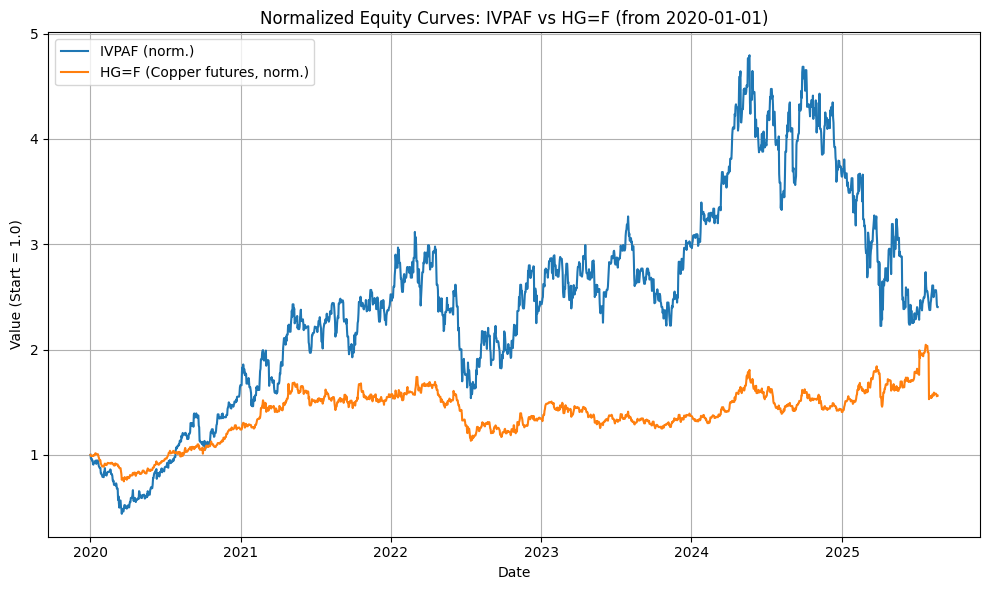

In [1]:
# Comparison equity curve: IVPAF vs HG=F (Copper Futures)
# Requires: yfinance, pandas, matplotlib
# pip install yfinance pandas matplotlib

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date
import yfinance as yf

START = "2020-01-01"
END = date.today().strftime("%Y-%m-%d")  # today's date

tickers = ["IVPAF", "HG=F"]

# Download Adj Close; auto_adjust=True gives adjusted prices
data = yf.download(
    tickers=tickers,
    start=START,
    end=END,
    auto_adjust=True,
    progress=False
)["Close"]  # yfinance returns "Close" when auto_adjust=True

# If a single column comes back (edge case), make it a DataFrame
if isinstance(data, pd.Series):
    data = data.to_frame()

# Align both series on the same calendar and fill short gaps (e.g., different holidays)
# Limit forward-fill to a few days to avoid smoothing long missing periods
aligned = (
    data.reindex(pd.date_range(START, END, freq="D"))
        .ffill(limit=5)
        .dropna(subset=["IVPAF", "HG=F"], how="any")
)

# Normalize to 1.0 at the first common date
norm = aligned / aligned.iloc[0]

# Plot (single axes, no specific colors/styles)
plt.figure(figsize=(10, 6))
plt.plot(norm.index, norm["IVPAF"], label="IVPAF (norm.)")
plt.plot(norm.index, norm["HG=F"], label="HG=F (Copper futures, norm.)")
plt.title("Normalized Equity Curves: IVPAF vs HG=F (from 2020-01-01)")
plt.xlabel("Date")
plt.ylabel("Value (Start = 1.0)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
